# **Alzheimer Prediction with MR Images** 

## *About the Dataset*

* Total 6400 images belongs to 4 different classes:

    - Mild Demented
    - Moderate Demented
    - Non Demented
    - Very Mild Demented


## *Importing required packages*

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import math
import os
import warnings
warnings.filterwarnings('ignore')
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import keras
from tensorflow import keras
from keras import Sequential
from keras import layers
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

## *Dataset Distribution*

There are 896 images in the Mild_Demented folder.
There are 64 images in the Moderate_Demented folder.
There are 3200 images in the Non_Demented folder.
There are 2240 images in the Very_Mild_Demented folder.


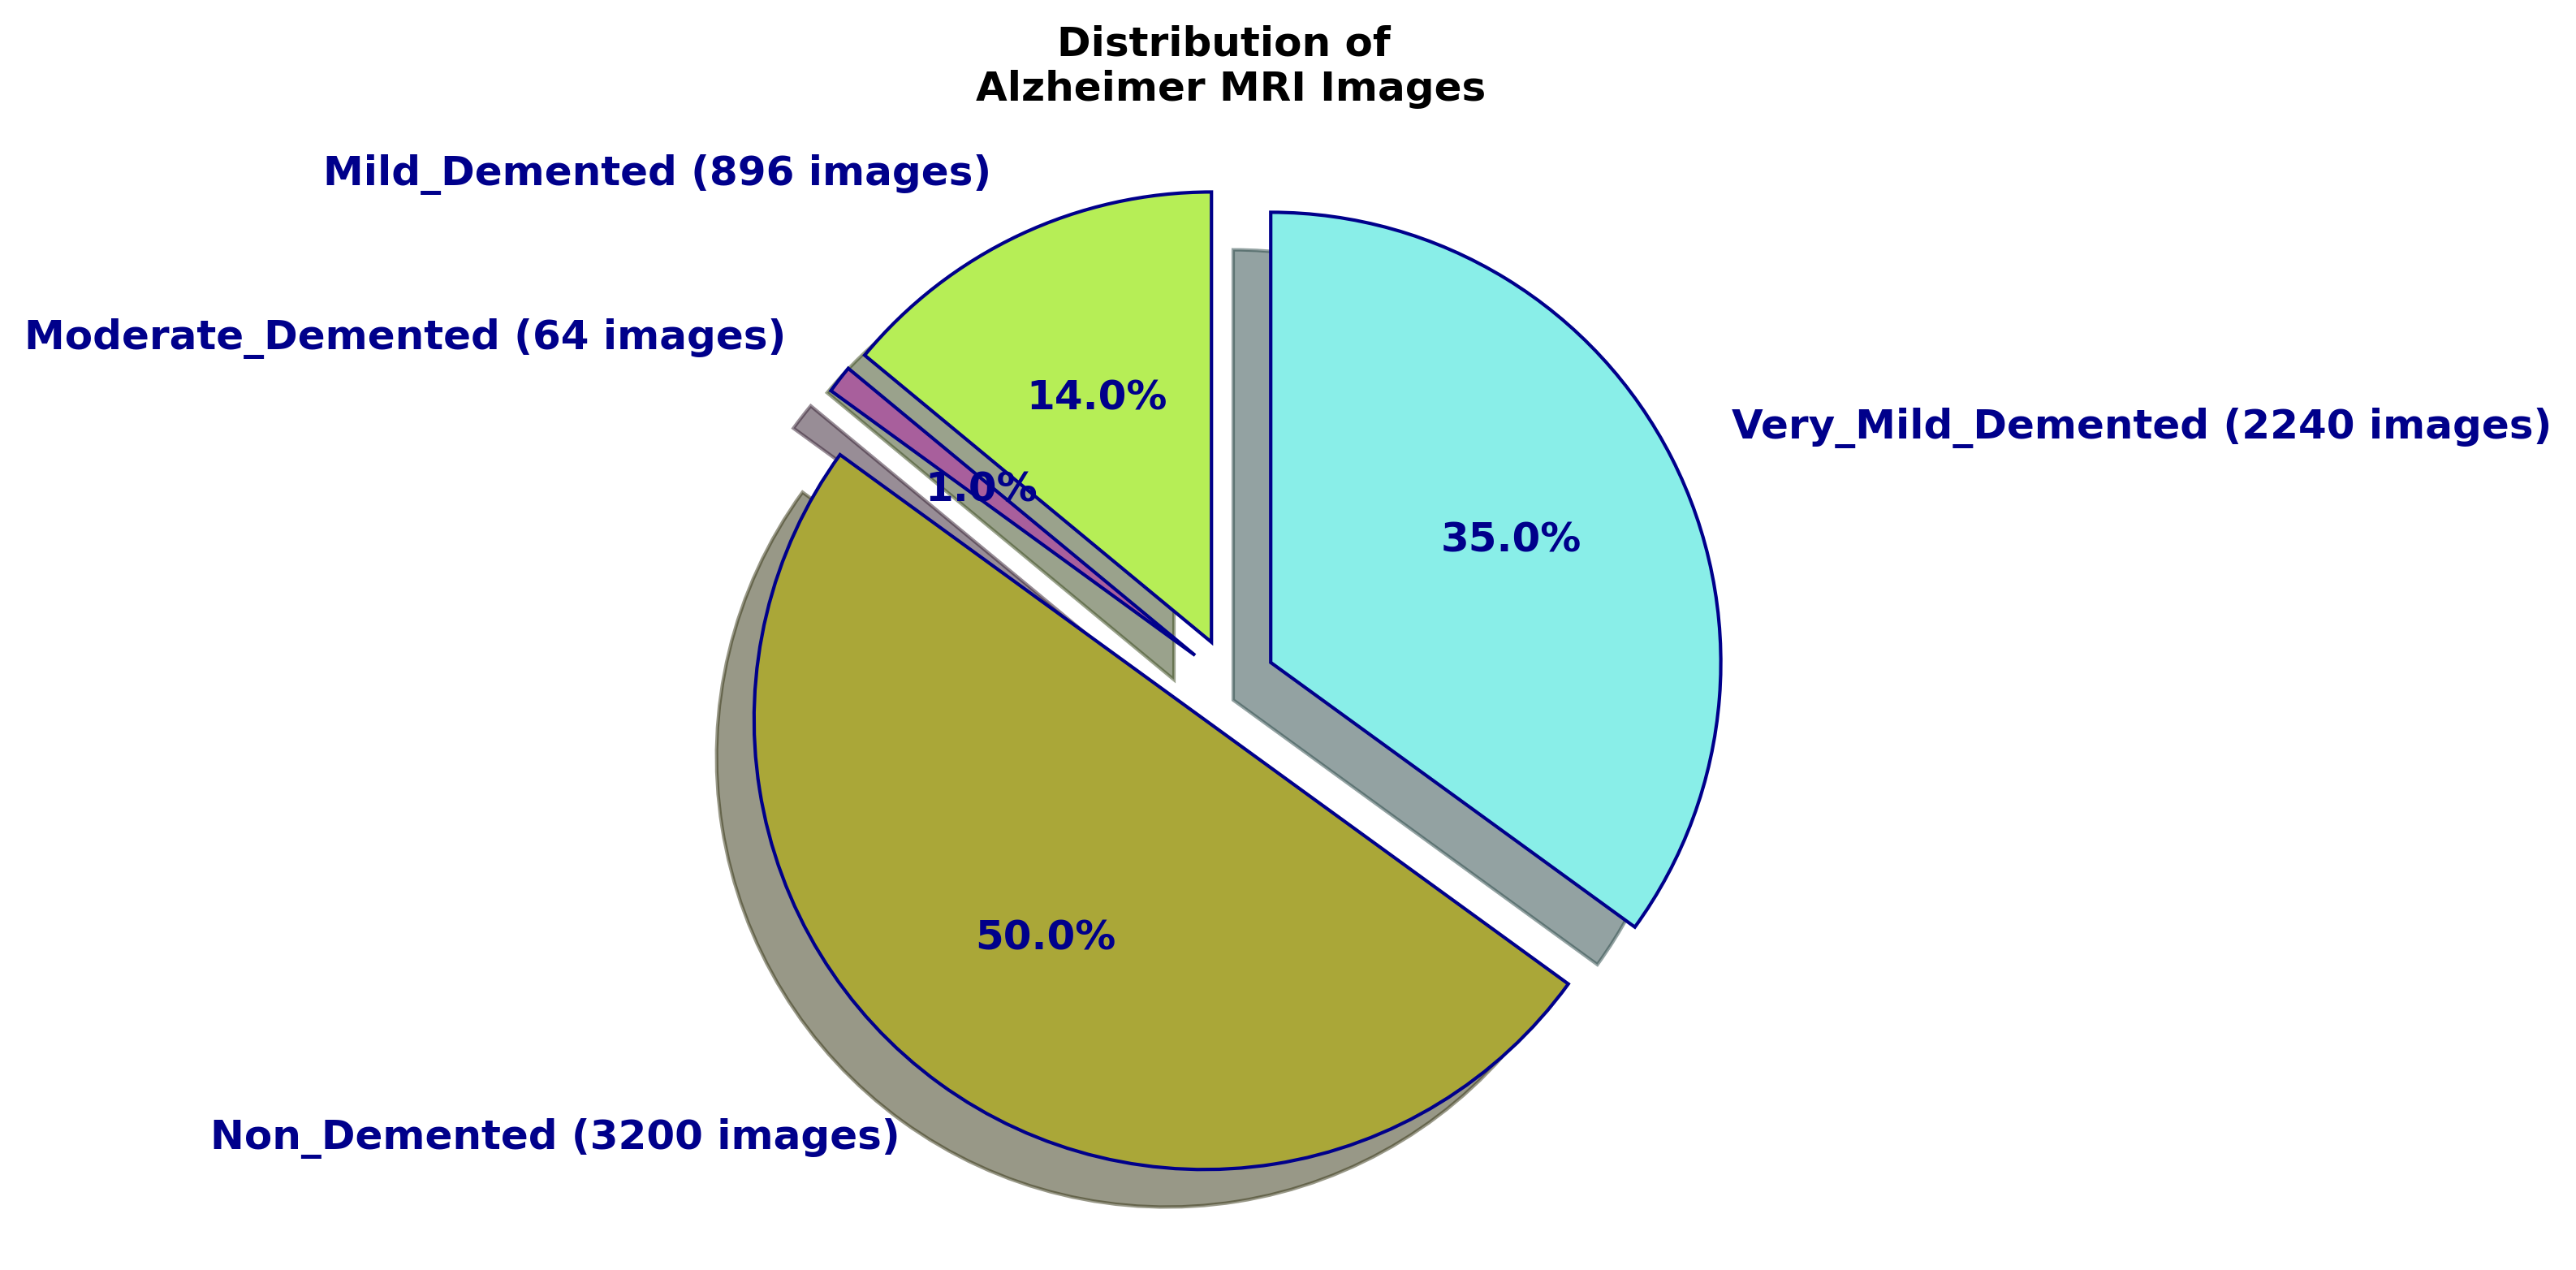

In [5]:
class_dist = {}
plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams['figure.dpi'] = 300
colors = ["#B6EE56", "#A85F9C", "#AAA738", "#89EEE8"]
def image_counter(folder_path):
    image_extensions = ['.jpg', '.jpeg', '.png']

    for root, dirs, _ in os.walk(folder_path):
        for dir_name in dirs:
            dir_path = os.path.join(root, dir_name)
            count = 0

            for filename in os.listdir(dir_path):
                file_ext = os.path.splitext(filename)[1].lower()

                if file_ext in image_extensions:
                    count += 1
            
            class_dist[dir_name] = count
            print(f"There are \033[35m{count}\033[0m images in the {dir_name} folder.")
    
    keys = list(class_dist.keys())
    values = list(class_dist.values())
    explode = (0.1,)*len(keys)
    
    labels = [f'{key} ({value} images)' for key, value in zip(keys, values)]
    
    plt.pie(values, explode=explode,labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90, colors=colors, textprops={'fontsize': 12, "fontweight" : "bold", "color":"darkblue"},  wedgeprops=
           {'edgecolor':'darkblue'} , labeldistance=1.15)
    plt.title("Distribution of \nAlzheimer MRI Images", size=12, fontweight="bold")

PATH = 'Dataset'

image_counter(PATH)

* Moderate Demented class has very less images when comapred with others, this indicates a imbalance in the dataset.
* Class imbalance is managed by giving higher weights to the minority class. Class weight os inversly proportionaly to the frequencies.
* weight = (total number of samples)/ (number of classes×number of samples in class i)

## *Creating Tensorflow Dataset*

In [6]:
data = tf.keras.utils.image_dataset_from_directory(PATH,
                                                batch_size = 32,
                                                image_size=(128, 128),
                                                shuffle=True,
                                                seed=42,)

class_names = data.class_names
class_names

Found 6400 files belonging to 4 classes.


['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']

In [7]:
data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

### *Samples for each class*

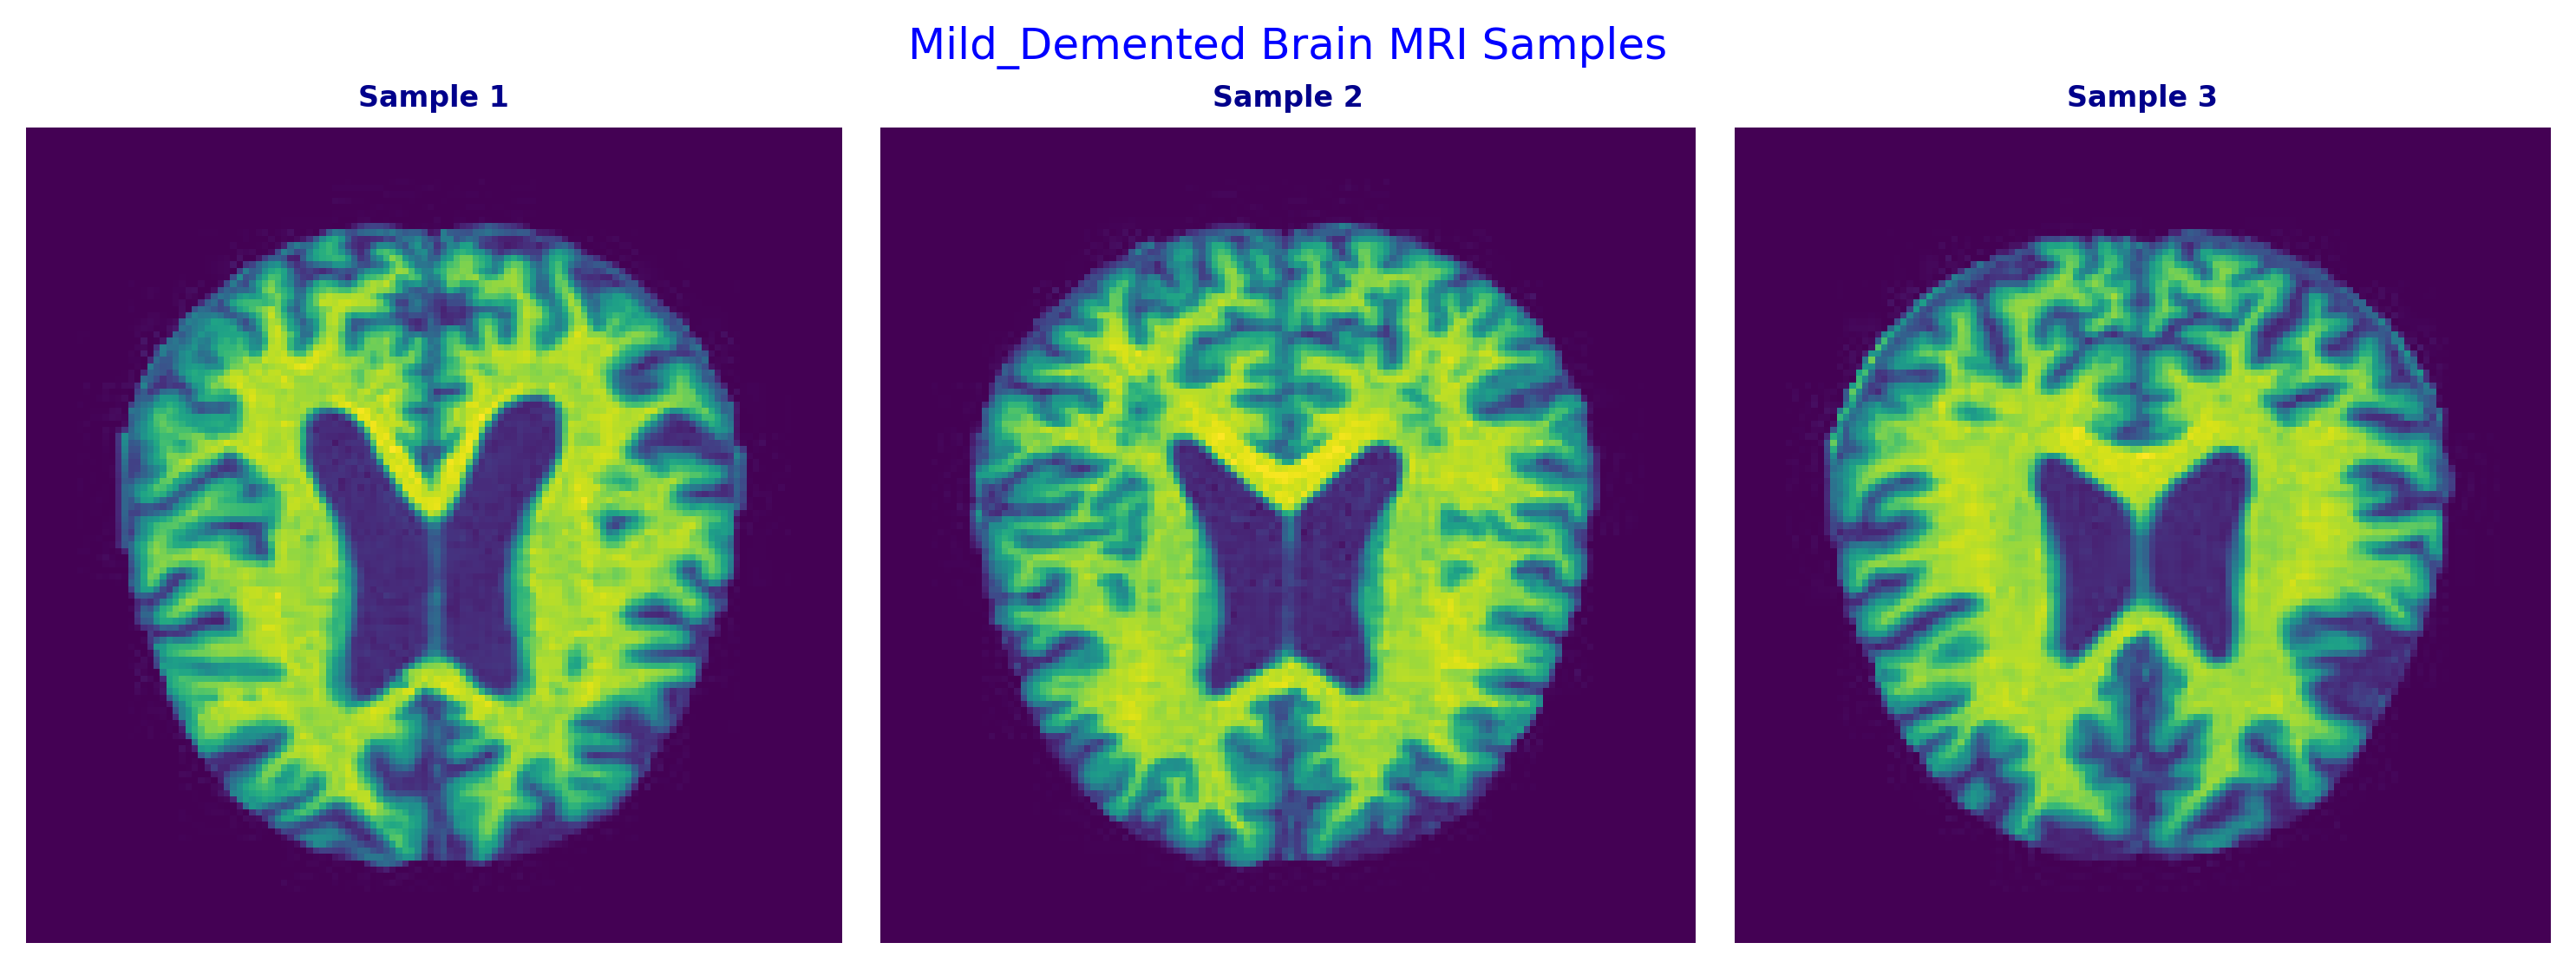

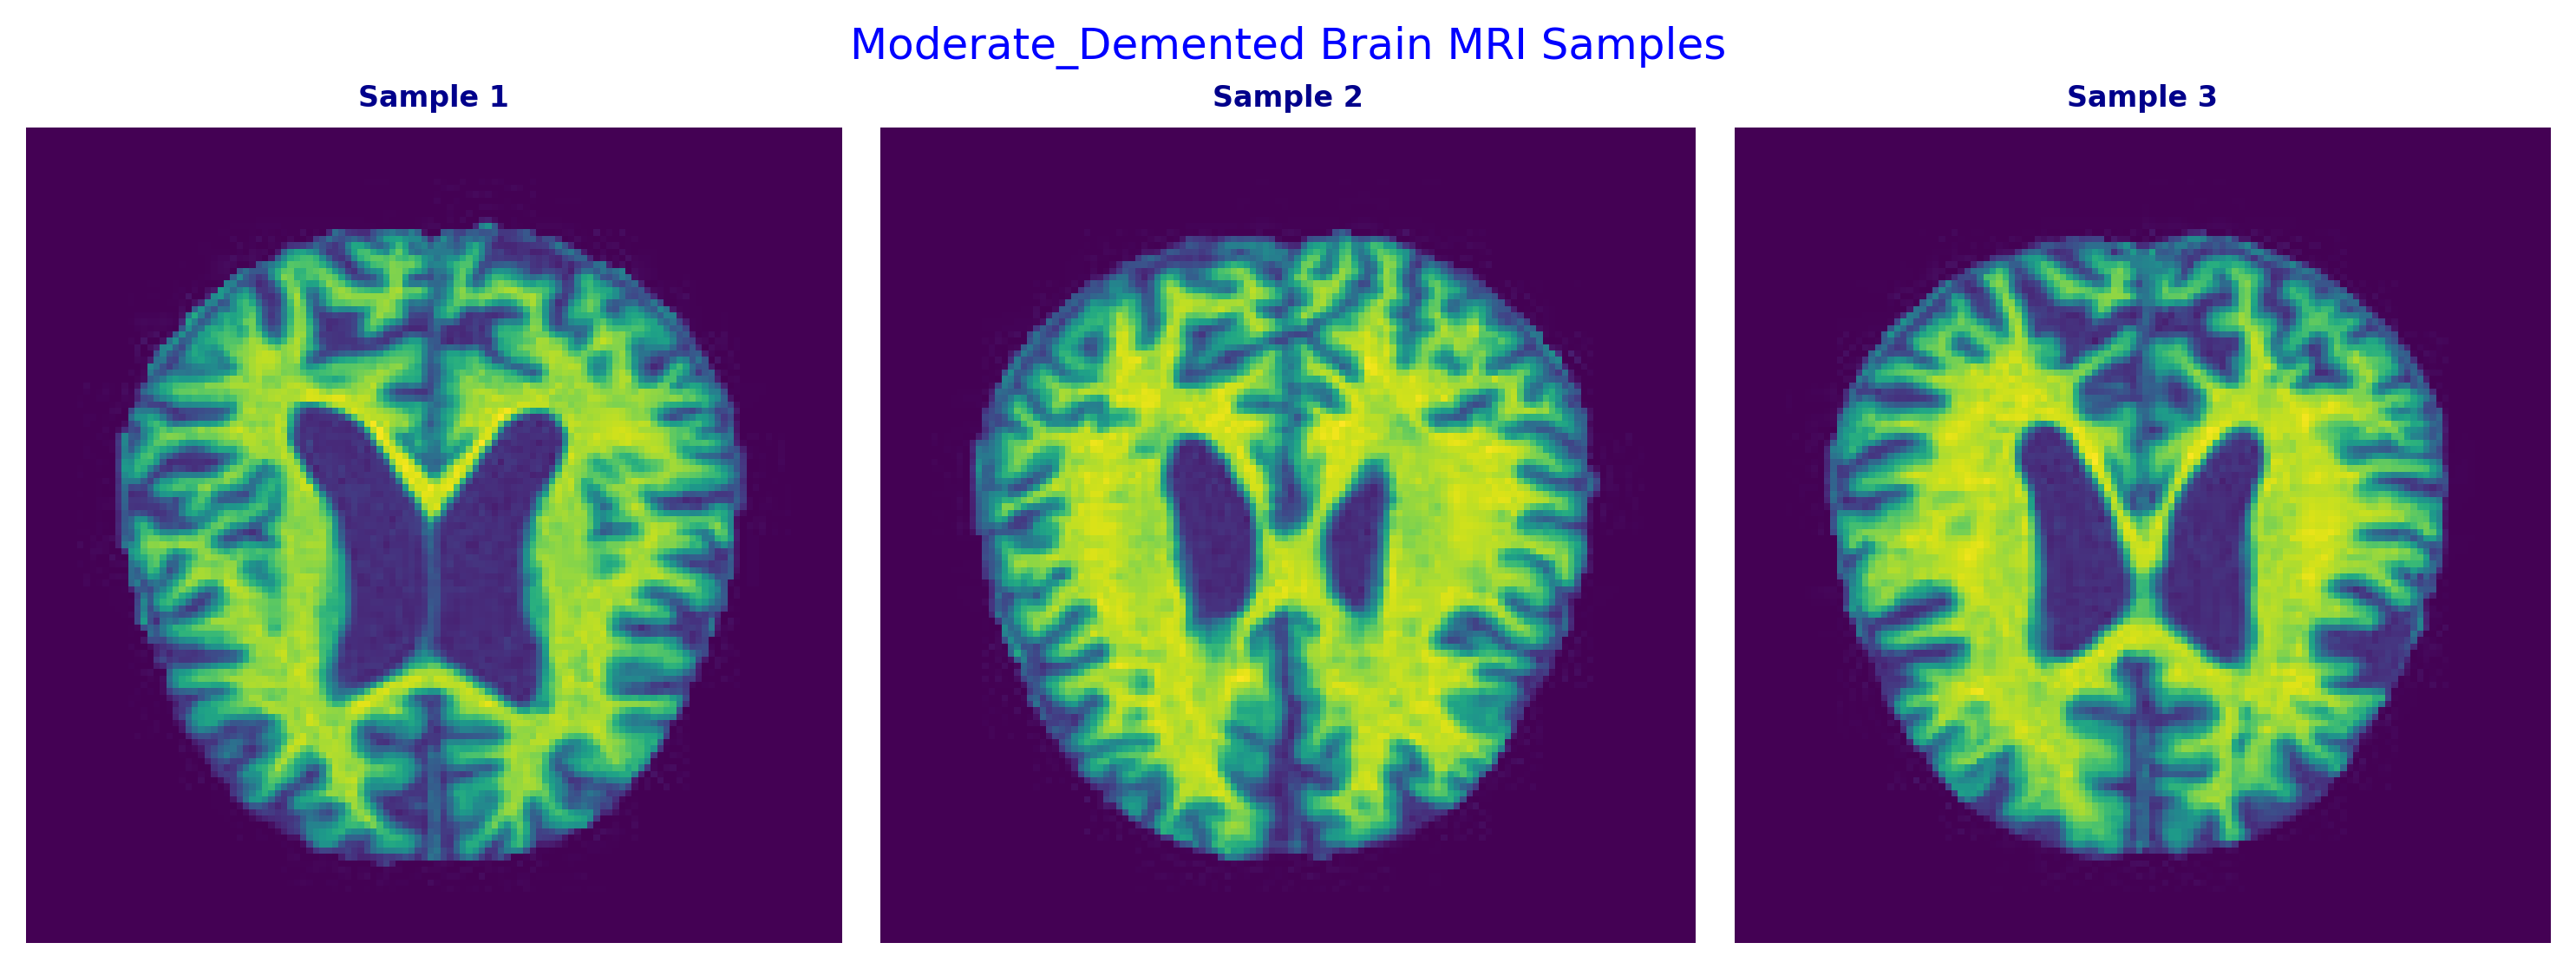

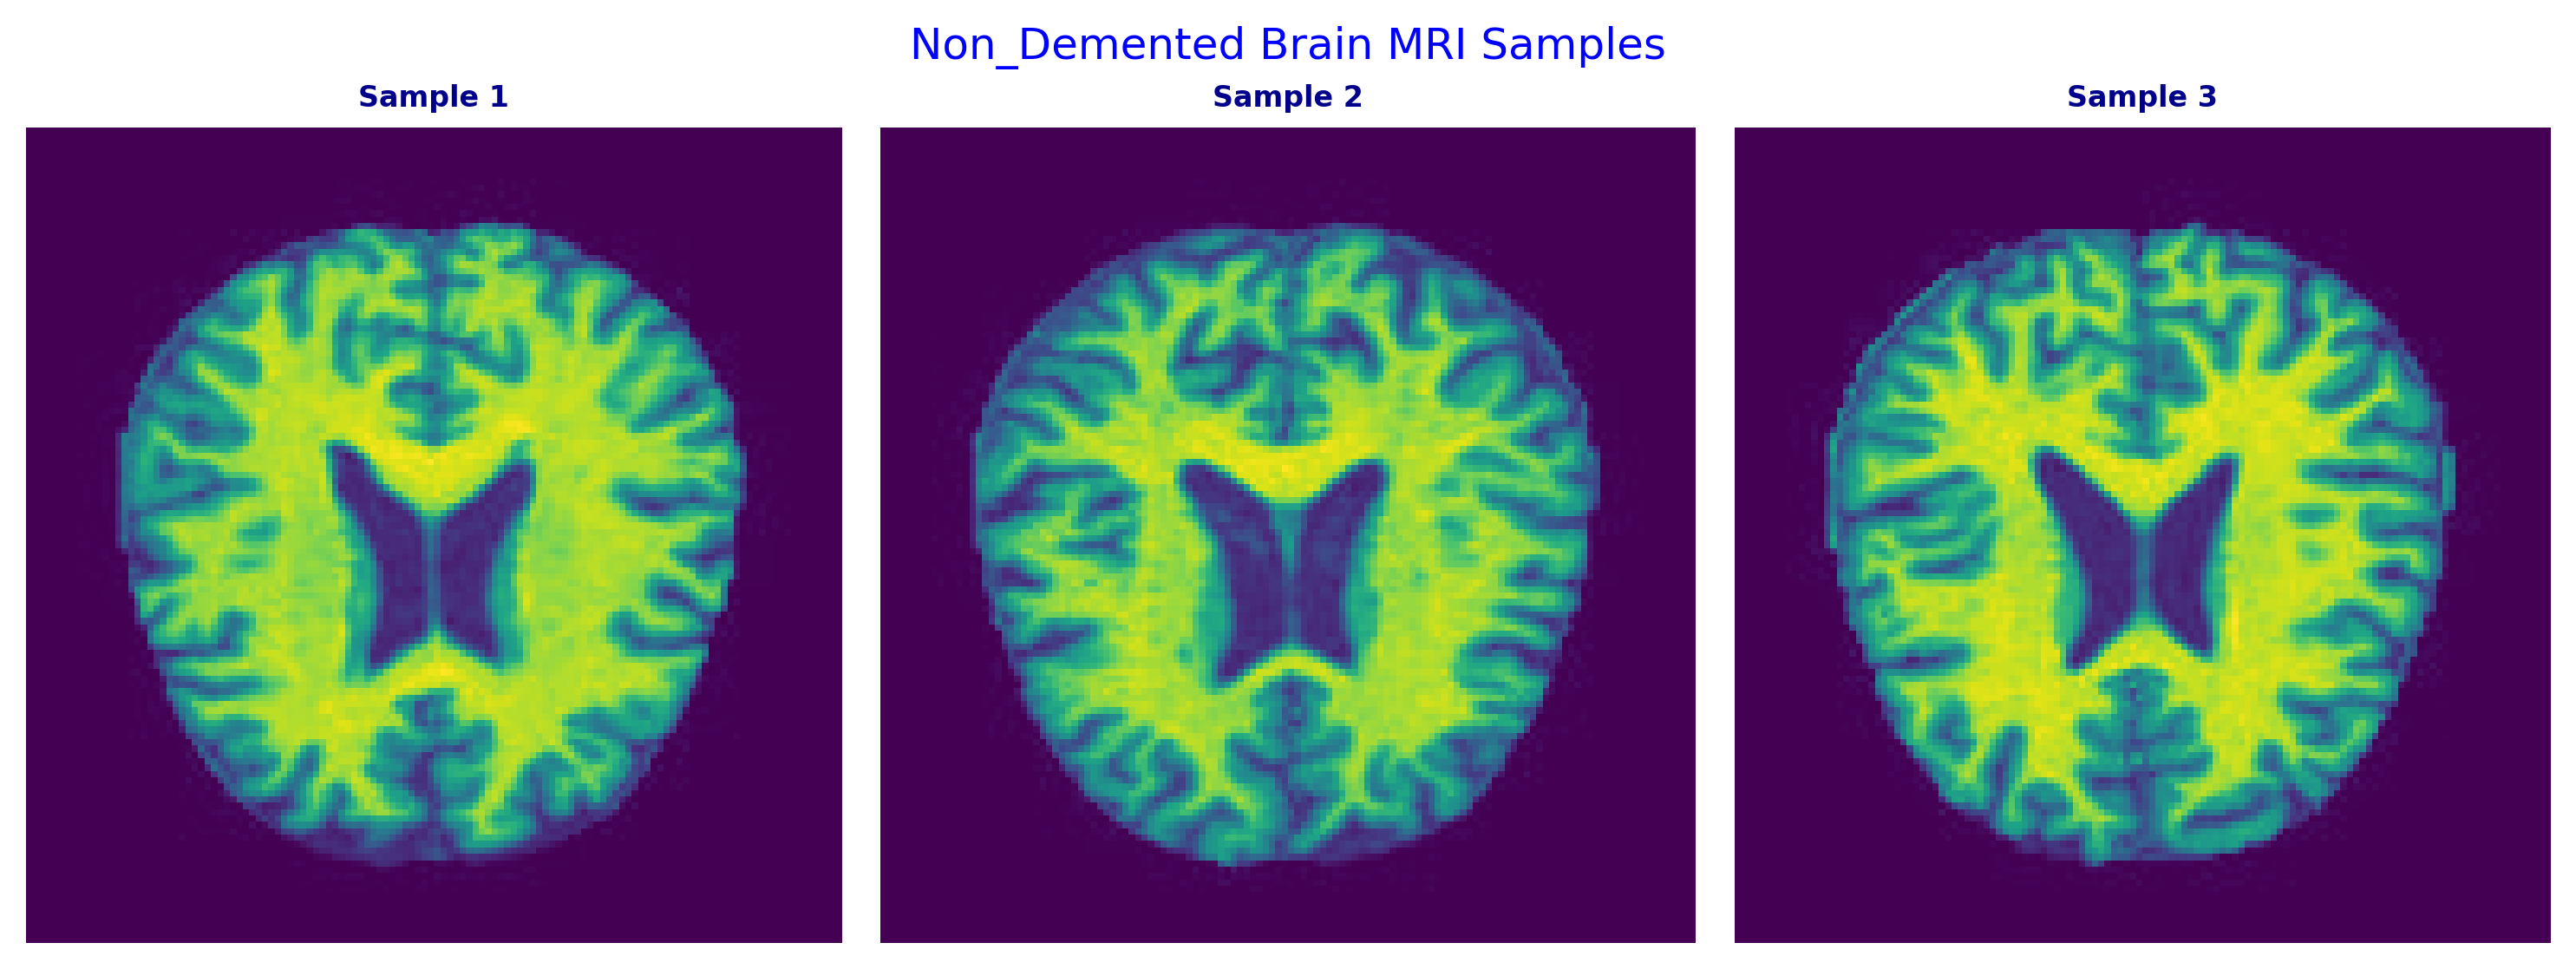

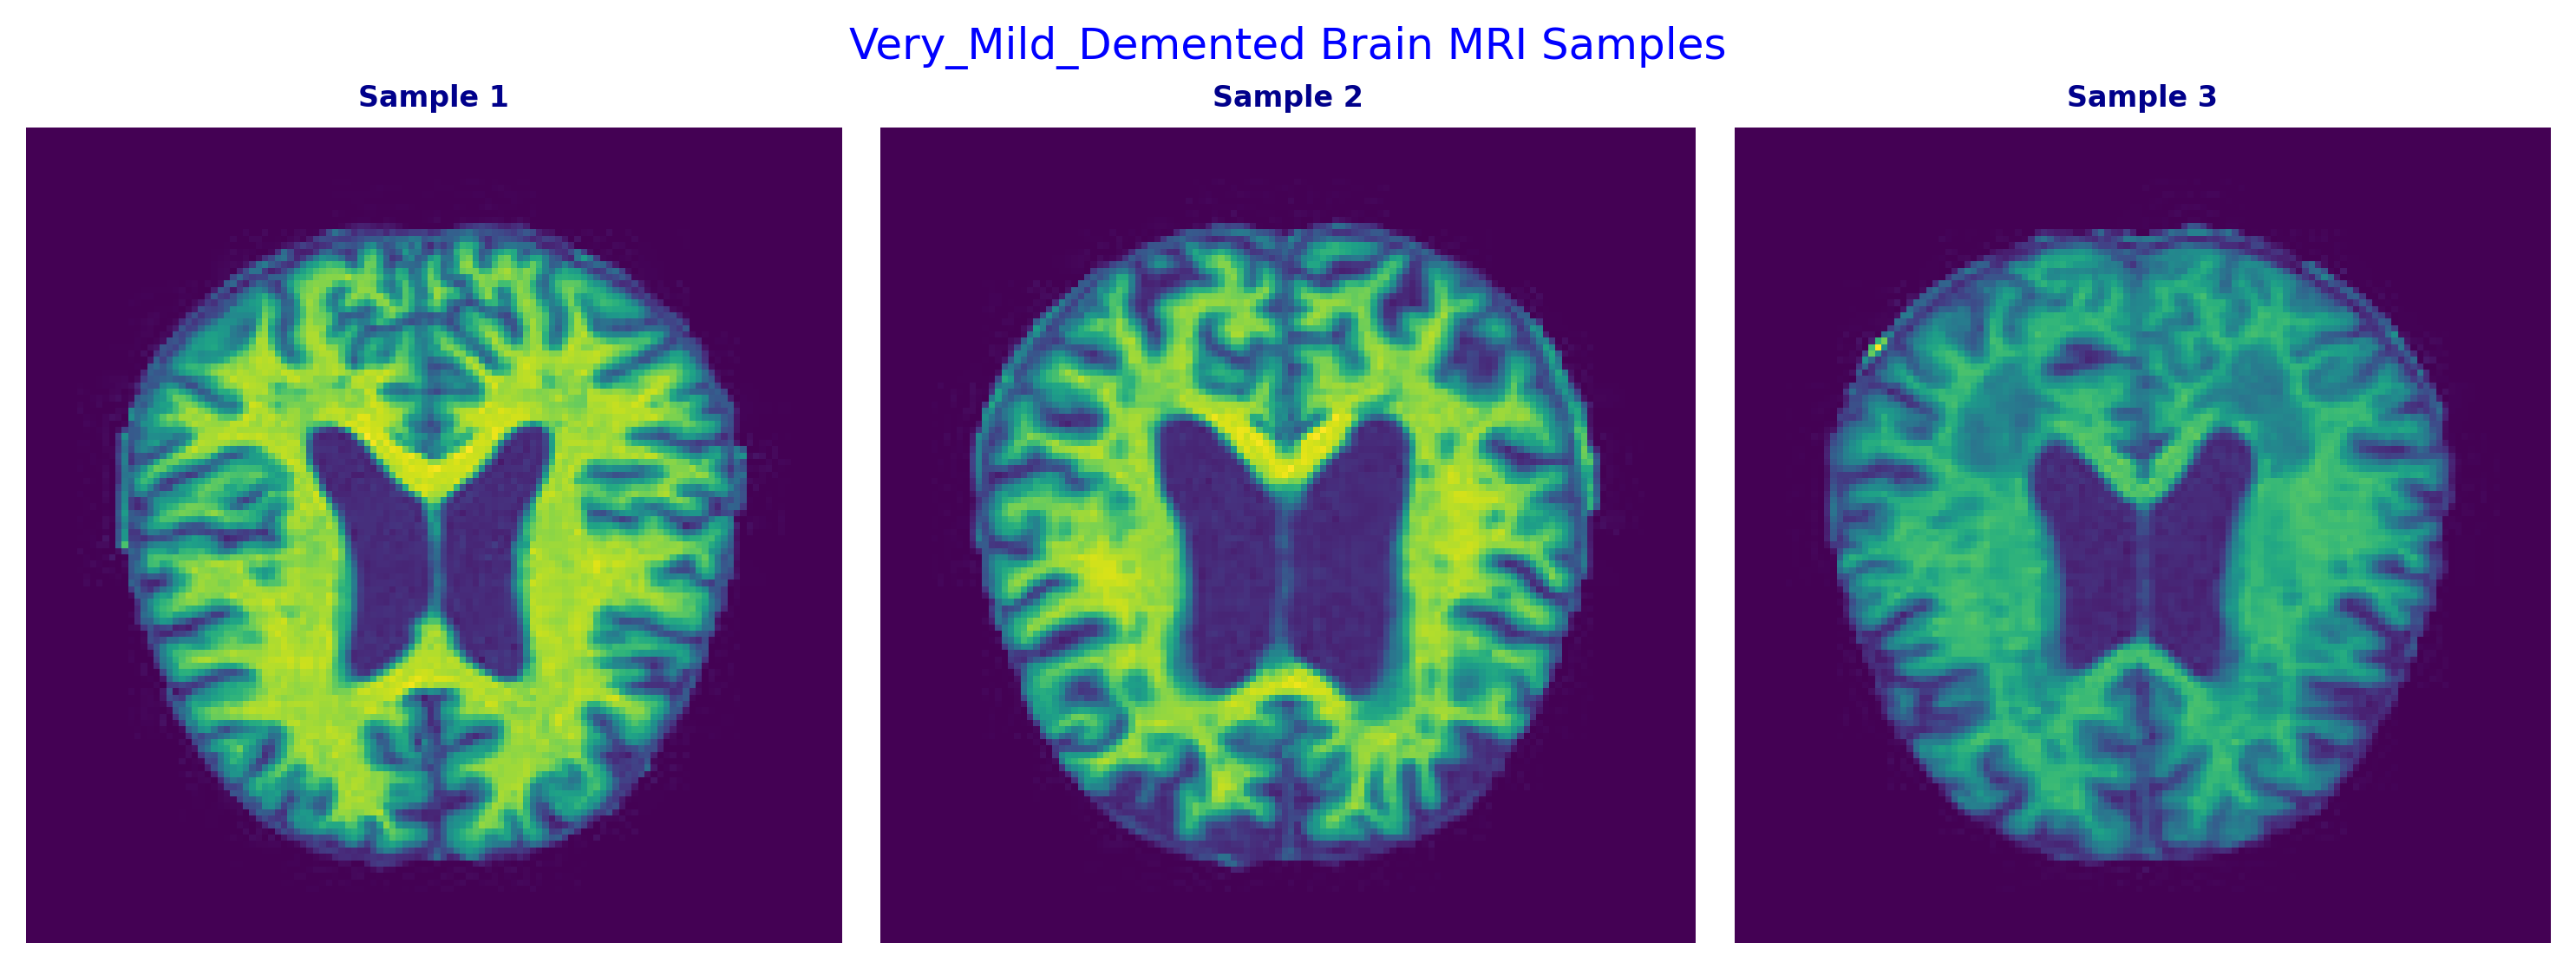

In [8]:
# Samples of the images
def sample_bringer(path, target, num_samples=3):
    
    class_path = os.path.join(path, target)

    image_files = [image for image in os.listdir(class_path) if image.endswith('.jpg')]

    fig, ax = plt.subplots(1, num_samples, facecolor="white")
    fig.suptitle(f'{target} Brain MRI Samples', color="Blue",fontsize=12, y=.8)
    
    for i in range(num_samples):
        image_path = os.path.join(class_path, image_files[i])
        img = mpimg.imread(image_path)

        ax[i].imshow(img)
        ax[i].axis('off')
        ax[i].set_title(f'Sample {i+1}', color="darkblue", fontsize=8, fontweight="bold", y=1)

    plt.tight_layout()
    
for target in class_names:
    sample_bringer(PATH, target=target)

### Dataset Splitting

In [9]:
# Function to split the data into train, test and validation sets
def train_test_val_split(train_size, val_size, test_size):
    train = int(len(data)*train_size)  
    test = int(len(data)*test_size)
    val = int(len(data)*val_size)
    
    train_data = data.take(train)
    val_data = data.skip(train).take(val)
    test_data = data.skip(train+val).take(test)
    return train_data, val_data, test_data

In [10]:
train_data, val_data, test_data= train_test_val_split(train_size=0.8, val_size=0.1, test_size=0.1)

In [11]:
# Handling the class imbalance
y_train = tf.concat(list(map(lambda x: x[1], train_data)), axis=0)
class_weight = compute_class_weight('balanced',classes=np.unique(y_train), y=y_train.numpy())  # Compute the class weights, balanced 
class_weights = dict(zip(np.unique(y_train), class_weight))

## *Model Building*

## Model 1:

In [12]:
def build_model():
    model_1 = Sequential()

    model_1.add(Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), activation="relu", kernel_initializer='he_normal',
                   input_shape=(128, 128, 3)))
    model_1.add(MaxPooling2D(pool_size=(2, 2)))
    model_1.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), activation="relu", kernel_initializer='he_normal'))
    model_1.add(MaxPooling2D(pool_size=(2, 2)))

    model_1.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation="relu", kernel_initializer='he_normal'))
    model_1.add(MaxPooling2D(pool_size=(2, 2)))

    model_1.add(Flatten())
    model_1.add(Dense(128, activation="relu", kernel_initializer='he_normal'))
    model_1.add(Dense(64, activation="relu"))
    model_1.add(Dense(4, activation="softmax"))
    model_1.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])

    model_1.summary()

    return model_1

model_1 = build_model()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,261,988 (12.44 MB)

 Trainable params: 3,261,988 (12.44 MB)

 Non-trainable params: 0 (0.00 B)

## Model 2:

In [13]:
def build_simplified_model():
    model_2 = Sequential()

    # First convolutional layer
    model_2.add(Conv2D(filters=32, kernel_size=(5, 5), strides=(1, 1), activation="relu", kernel_initializer='he_normal',
                   input_shape=(128, 128, 3)))
    model_2.add(MaxPooling2D(pool_size=(2, 2)))

    # Second convolutional layer
    model_2.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation="relu", kernel_initializer='he_normal'))
    model_2.add(MaxPooling2D(pool_size=(2, 2)))

    # Third convolutional layer
    model_2.add(Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation="relu", kernel_initializer='he_normal'))
    model_2.add(MaxPooling2D(pool_size=(2, 2)))

    model_2.add(Flatten())

    # Directly to a final layer with the number of classes
    model_2.add(Dense(4, activation="softmax"))  # 4 classes

    model_2.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])

    model_2.summary()

    return model_2

model_simplified = build_simplified_model()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 124, 124, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 256)    │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │       200,708 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369,348 (1.41 MB)

 Trainable params: 369,348 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

## *Model 1 Callback*

In [50]:
from tensorflow import keras

checkpoint_filepath_1 = 'best_model_1.keras' 
def callback_model_1():
    callbacks_1 = [
        keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath_1,
             save_weights_only=False,
                           monitor='val_accuracy',
                           save_best_only=True,
                           verbose=1)  # Saves the entire model, not just weights
    ]
    return callbacks_1

* Early stopping is a form of regularization used to avoid overfitting when training a convolutional neural network (CNN) or any other kind of machine learning model. Overfitting occurs when a model learns the details and noise in the training data to an extent that it negatively impacts the performance of the model on new data

In [51]:
# Early stopping for any case of overfitting
def early_stopping(patience):
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, verbose=1)
    return es_callback

In [57]:
checkpoint_callback_1 = callback_model_1()
# patience refers to the number of epochs to continue training after detecting no improvement
early_stopping_1 = early_stopping(patience=5)
check_callbacks_1 = [checkpoint_callback_1, early_stopping_1]

## *Model 2 Callback*

In [60]:
checkpoint_filepath_2 = 'best_model_2.keras' 

def callback_model_2():
    callbacks_2 = [
        keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath_2,
            save_best_only=True,
            monitor="val_accuracy",
            mode='min',
            save_weights_only=False)  # Saves the entire model, not just weights
    ]
    return callbacks_2

In [61]:
checkpoint_callback_2 = callback_model_2()
early_stopping_2 = early_stopping(patience=5)
check_callbacks_2 = [checkpoint_callback_2, early_stopping_2]

## *Fit Model 1*

In [58]:
history_1 = model_1.fit(train_data, 
            epochs = 20, 
            validation_data = val_data,
            class_weight = class_weights, 
            callbacks = check_callbacks_1)

Epoch 1/20


160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.7181 - loss: 0.5604
Epoch 1: val_accuracy improved from -inf to 0.72188, saving model to best_model_1.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 29s 180ms/step - accuracy: 0.7179 - loss: 0.5608 - val_accuracy: 0.7219 - val_loss: 0.6406
Epoch 2/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.7836 - loss: 0.3697
Epoch 2: val_accuracy improved from 0.72188 to 0.83906, saving model to best_model_1.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 30s 183ms/step - accuracy: 0.7838 - loss: 0.3693 - val_accuracy: 0.8391 - val_loss: 0.4595
Epoch 3/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9050 - loss: 0.1588
Epoch 3: val_accuracy improved from 0.83906 to 0.84375, saving model to best_model_1.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 24s 146ms/step - accuracy: 0.9051 - loss: 0.1586 - val_accuracy: 0.8438 - val_loss: 0.4997
Epoch 4/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9630 - loss: 0.0698
Epoch 4: val_accuracy improve

## *Loss & Accuracy : Model 1*

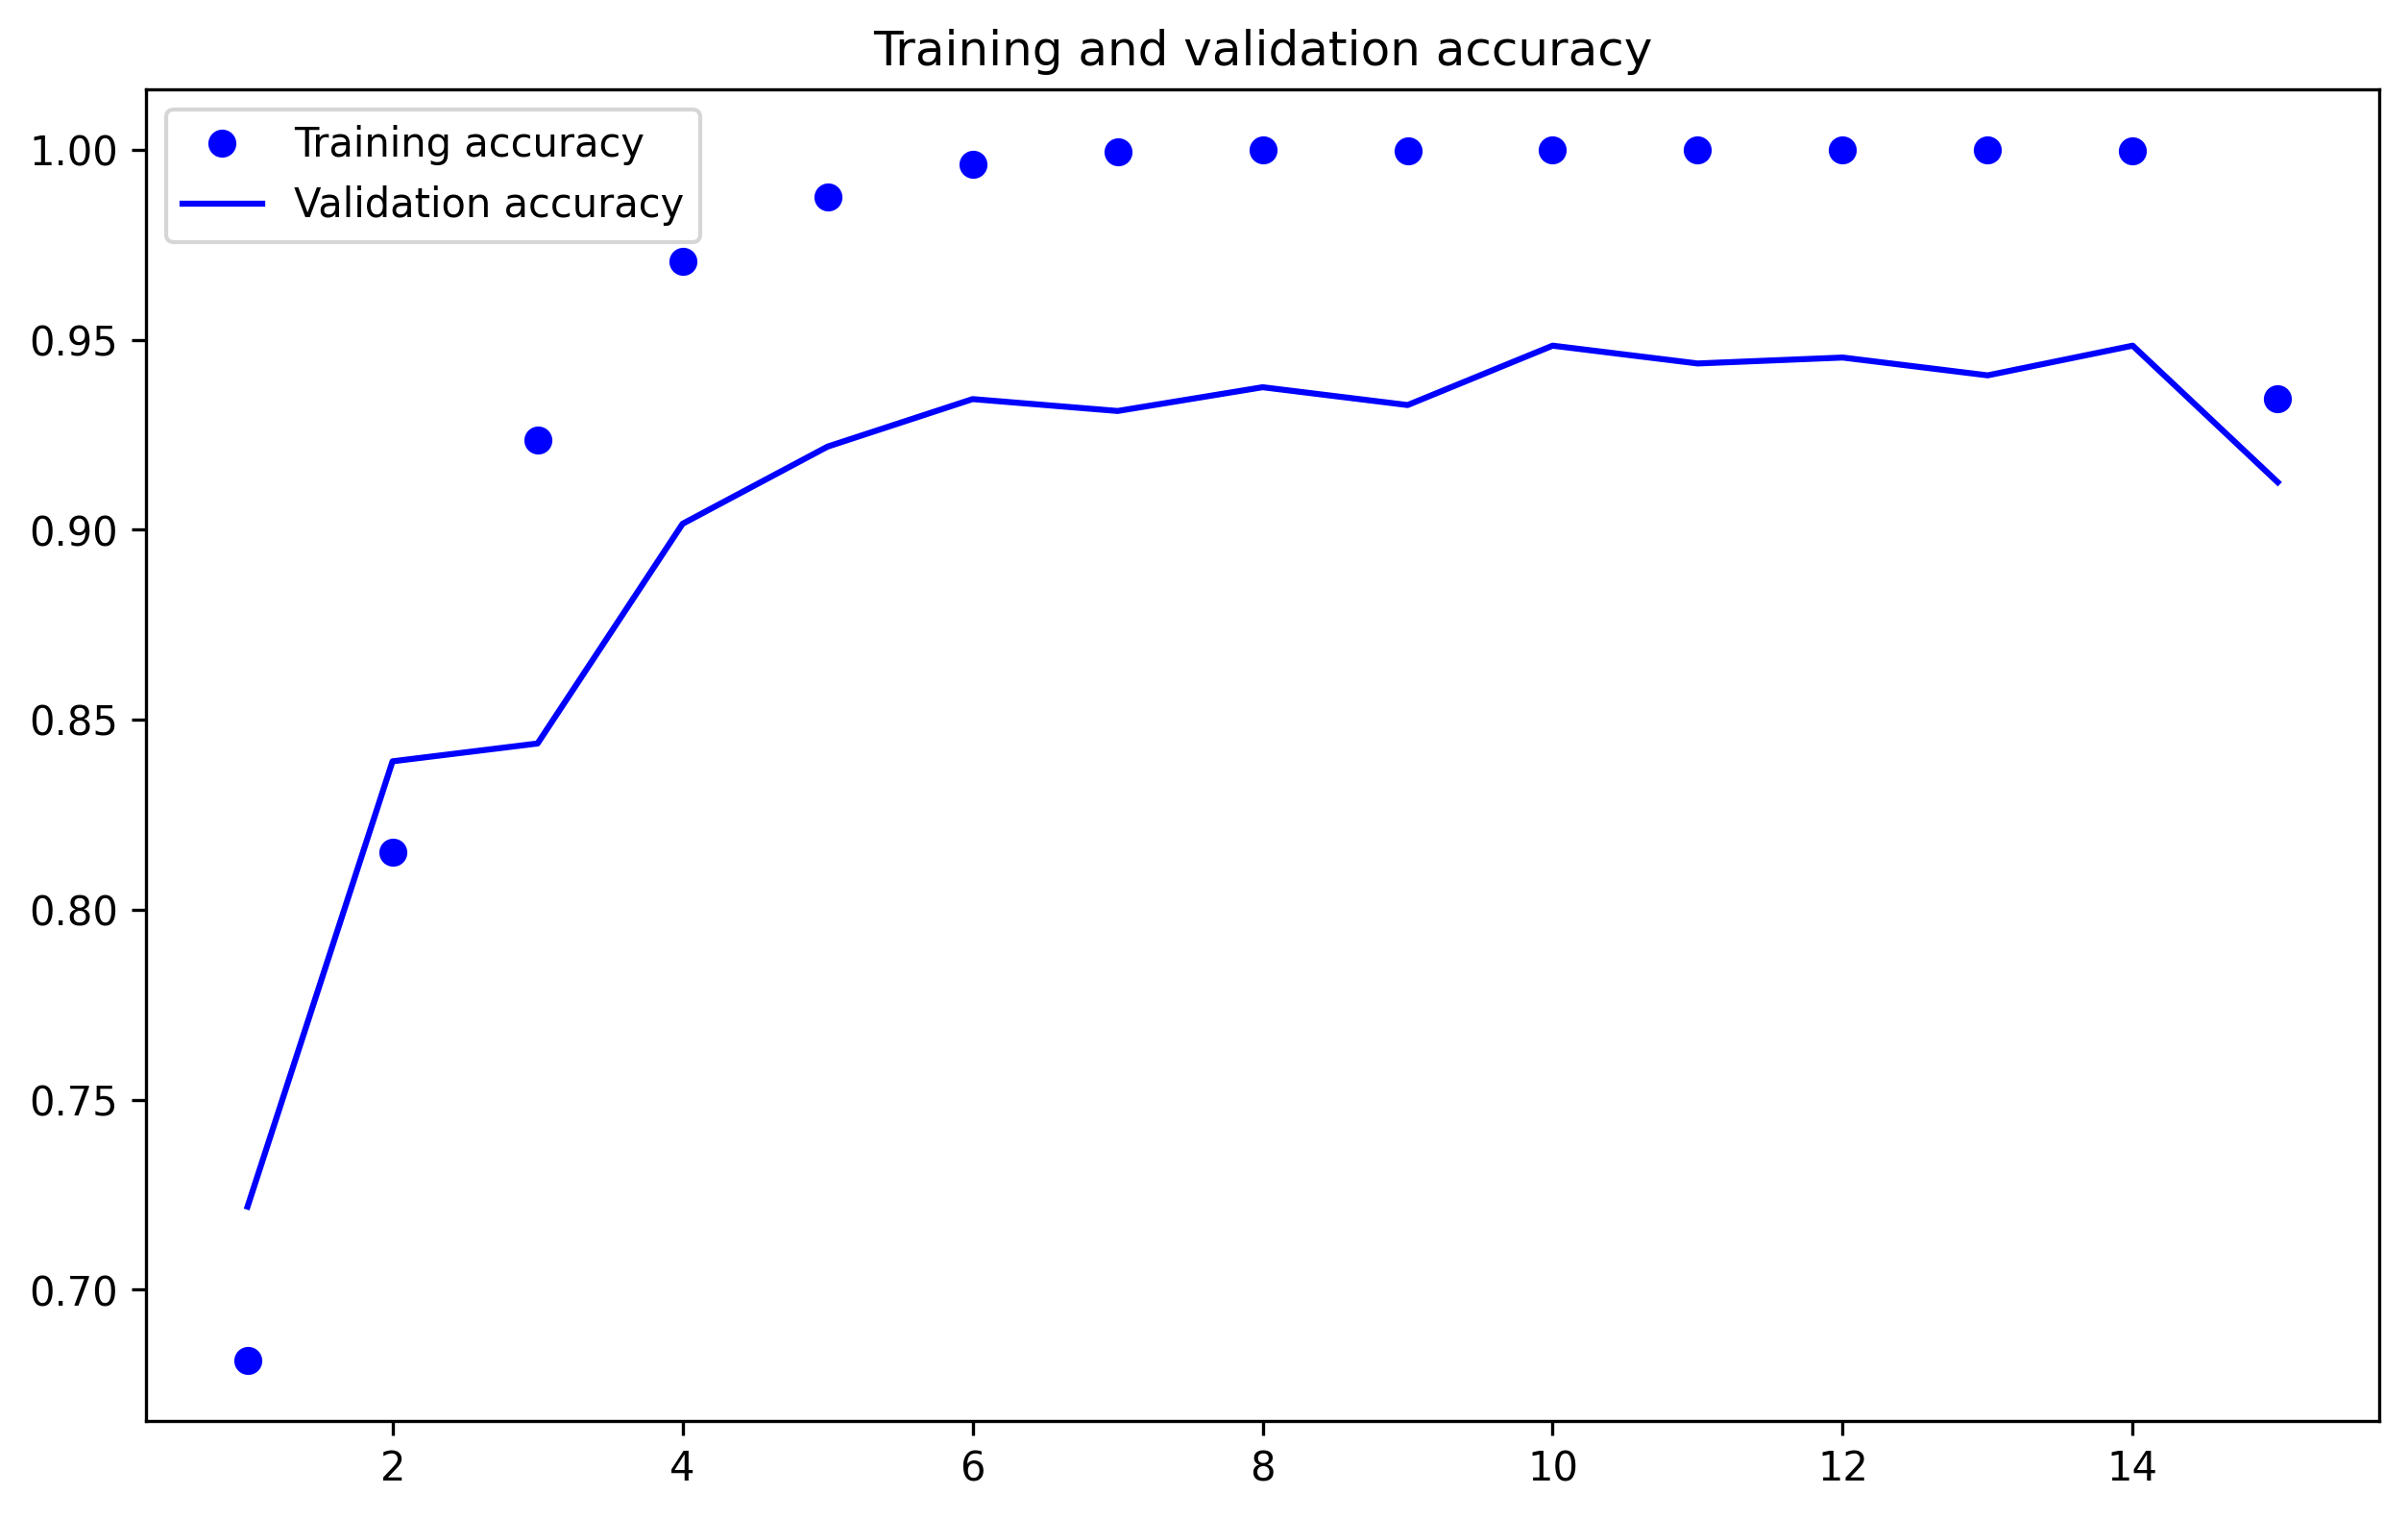

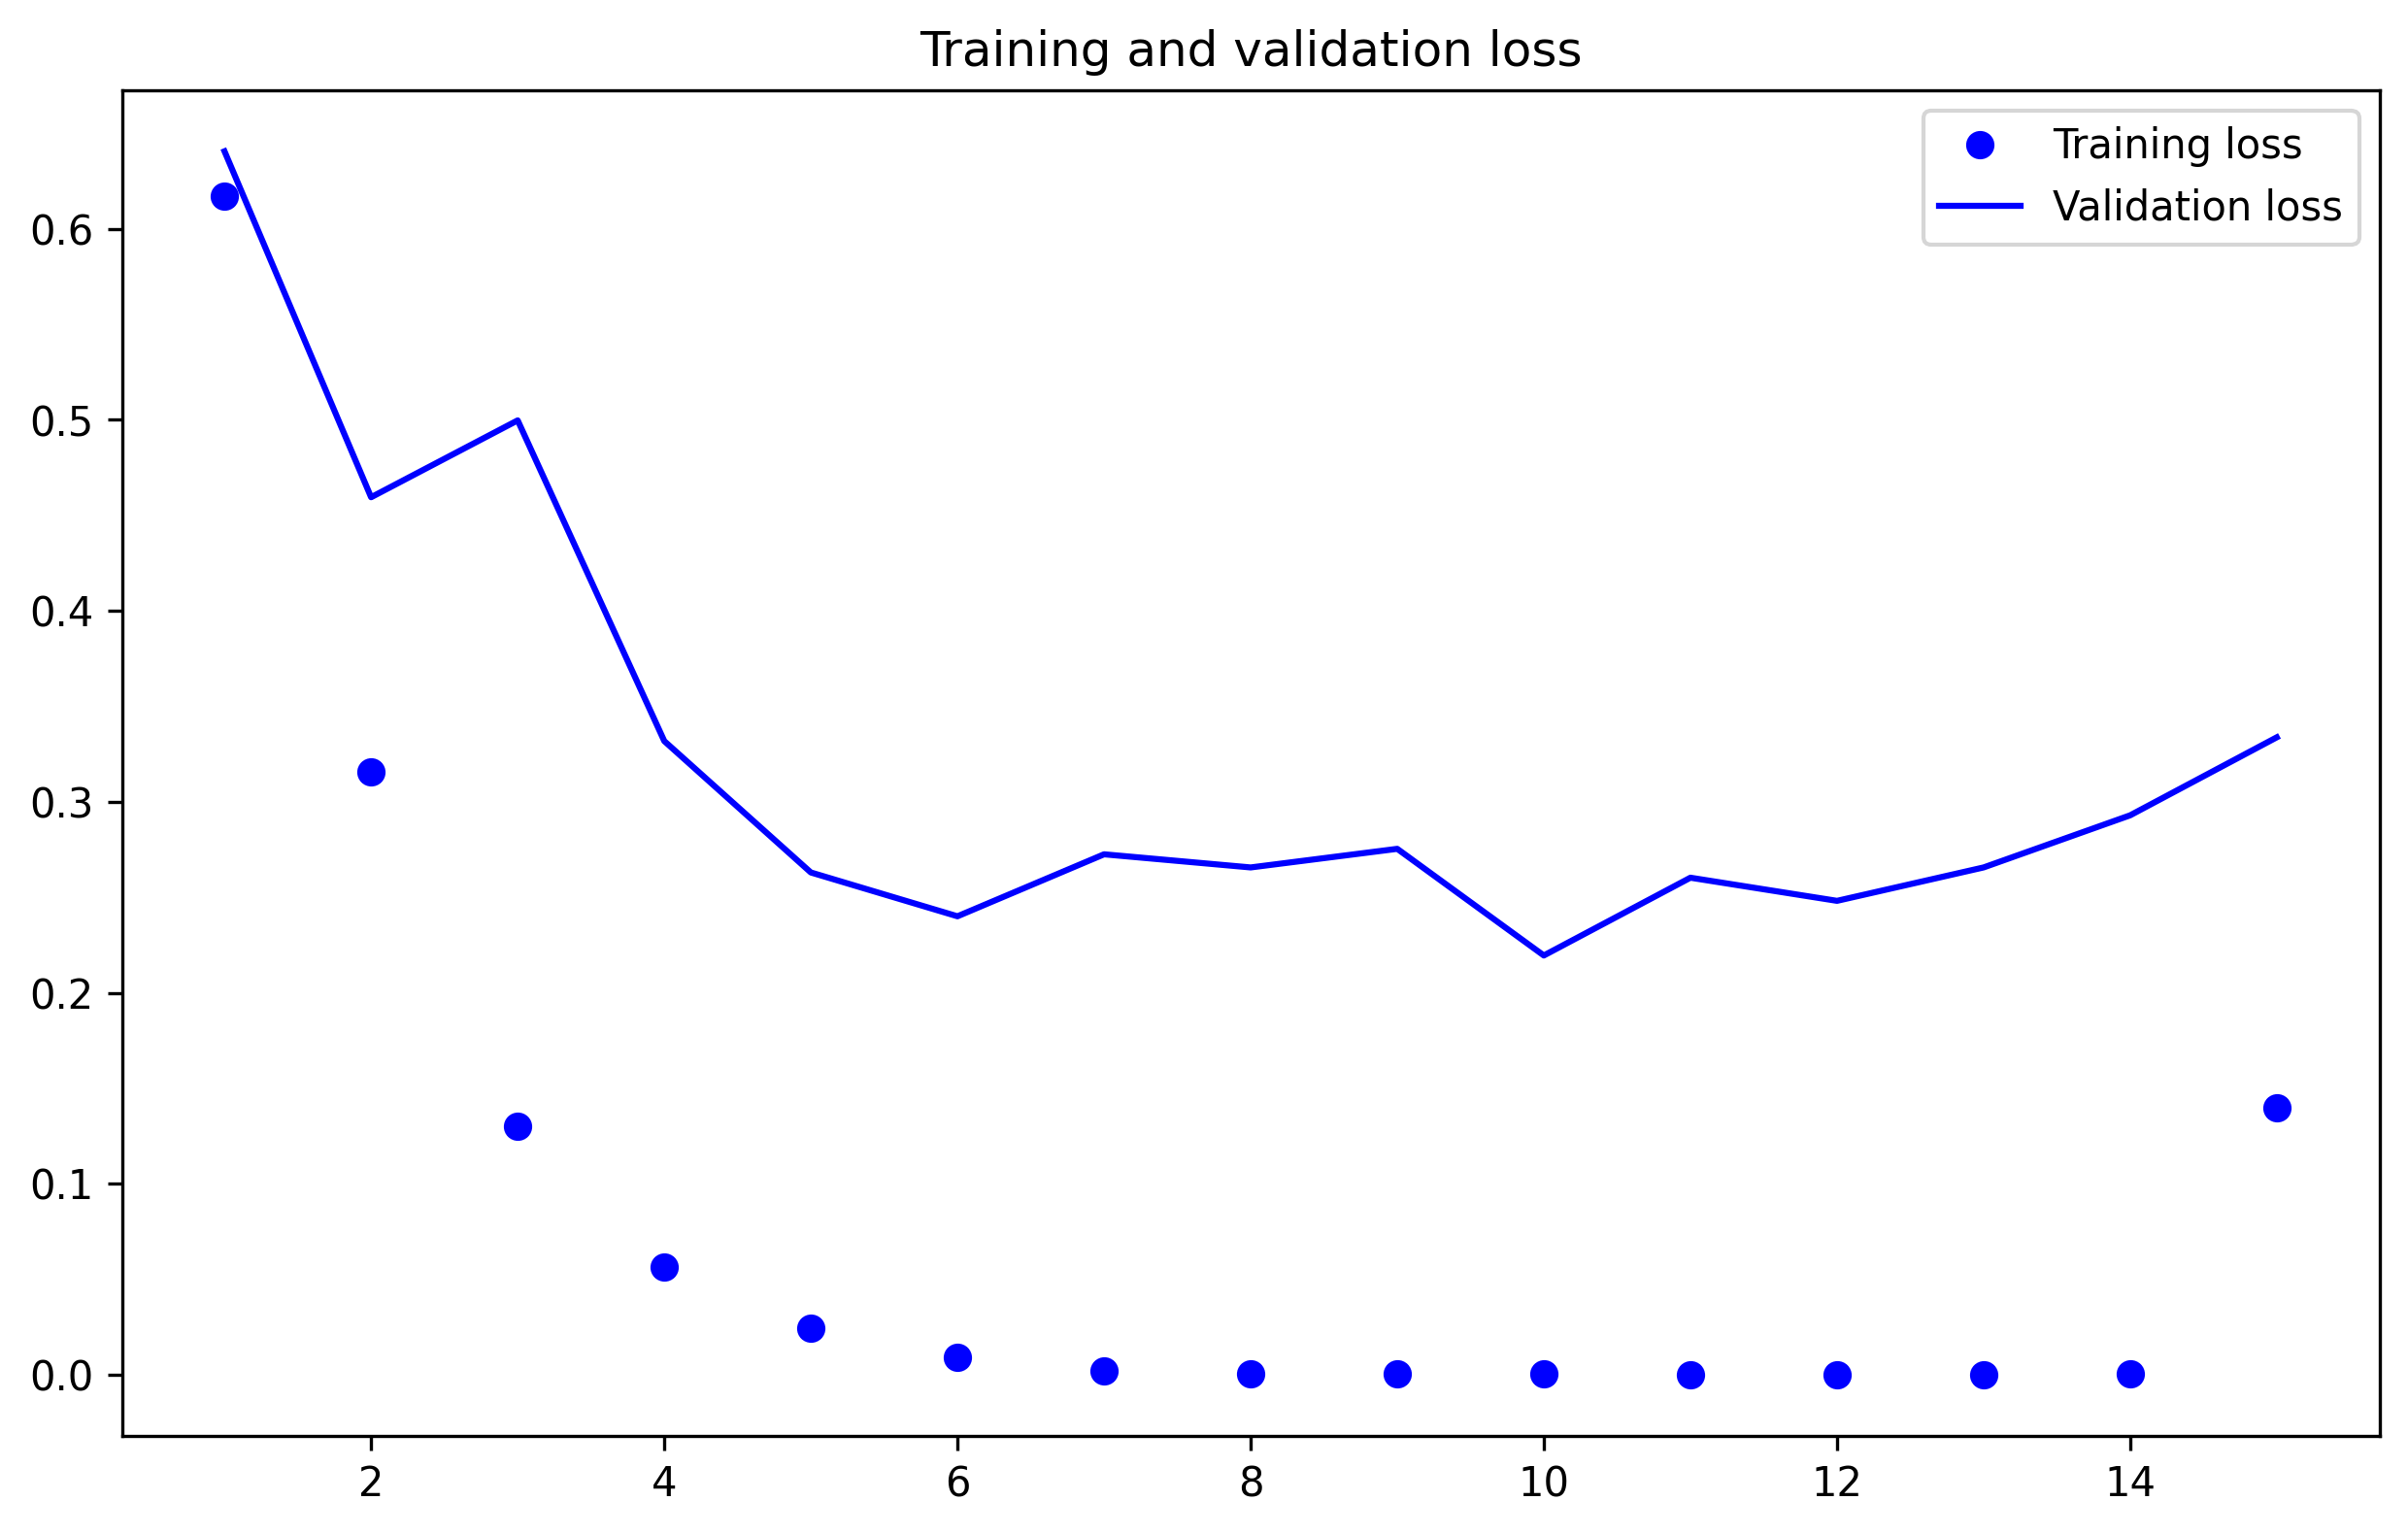

In [66]:
accuracy = history_1.history["accuracy"]
val_accuracy = history_1.history["val_accuracy"]
loss = history_1.history["loss"]
val_loss = history_1.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

* The model 1 has stopped by epoch 15 because we have used early stopping with a patience of 5.

## *Fit Model 2*

In [62]:
history_2 = model_simplified.fit(train_data, 
            epochs = 20, 
            validation_data = val_data,
            class_weight = class_weights, 
            callbacks = check_callbacks_2)

Epoch 1/20


160/160 ━━━━━━━━━━━━━━━━━━━━ 41s 248ms/step - accuracy: 0.3092 - loss: 383.3292 - val_accuracy: 0.4734 - val_loss: 1.1202
Epoch 2/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 49s 302ms/step - accuracy: 0.4841 - loss: 0.8903 - val_accuracy: 0.5656 - val_loss: 0.9612
Epoch 3/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 48s 301ms/step - accuracy: 0.6012 - loss: 0.6668 - val_accuracy: 0.7016 - val_loss: 0.7423
Epoch 4/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 46s 284ms/step - accuracy: 0.6781 - loss: 0.5631 - val_accuracy: 0.6781 - val_loss: 0.7402
Epoch 5/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 50s 309ms/step - accuracy: 0.7363 - loss: 0.4392 - val_accuracy: 0.7234 - val_loss: 0.7087
Epoch 6/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 65s 406ms/step - accuracy: 0.7844 - loss: 0.3642 - val_accuracy: 0.7078 - val_loss: 0.7362
Epoch 7/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 87s 539ms/step - accuracy: 0.7990 - loss: 0.3308 - val_accuracy: 0.7766 - val_loss: 0.5988
Epoch 8/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 77s 476ms/step - accuracy: 0.8744 - loss: 0.2215 - v

## *Loss & Accuracy : Model 2*

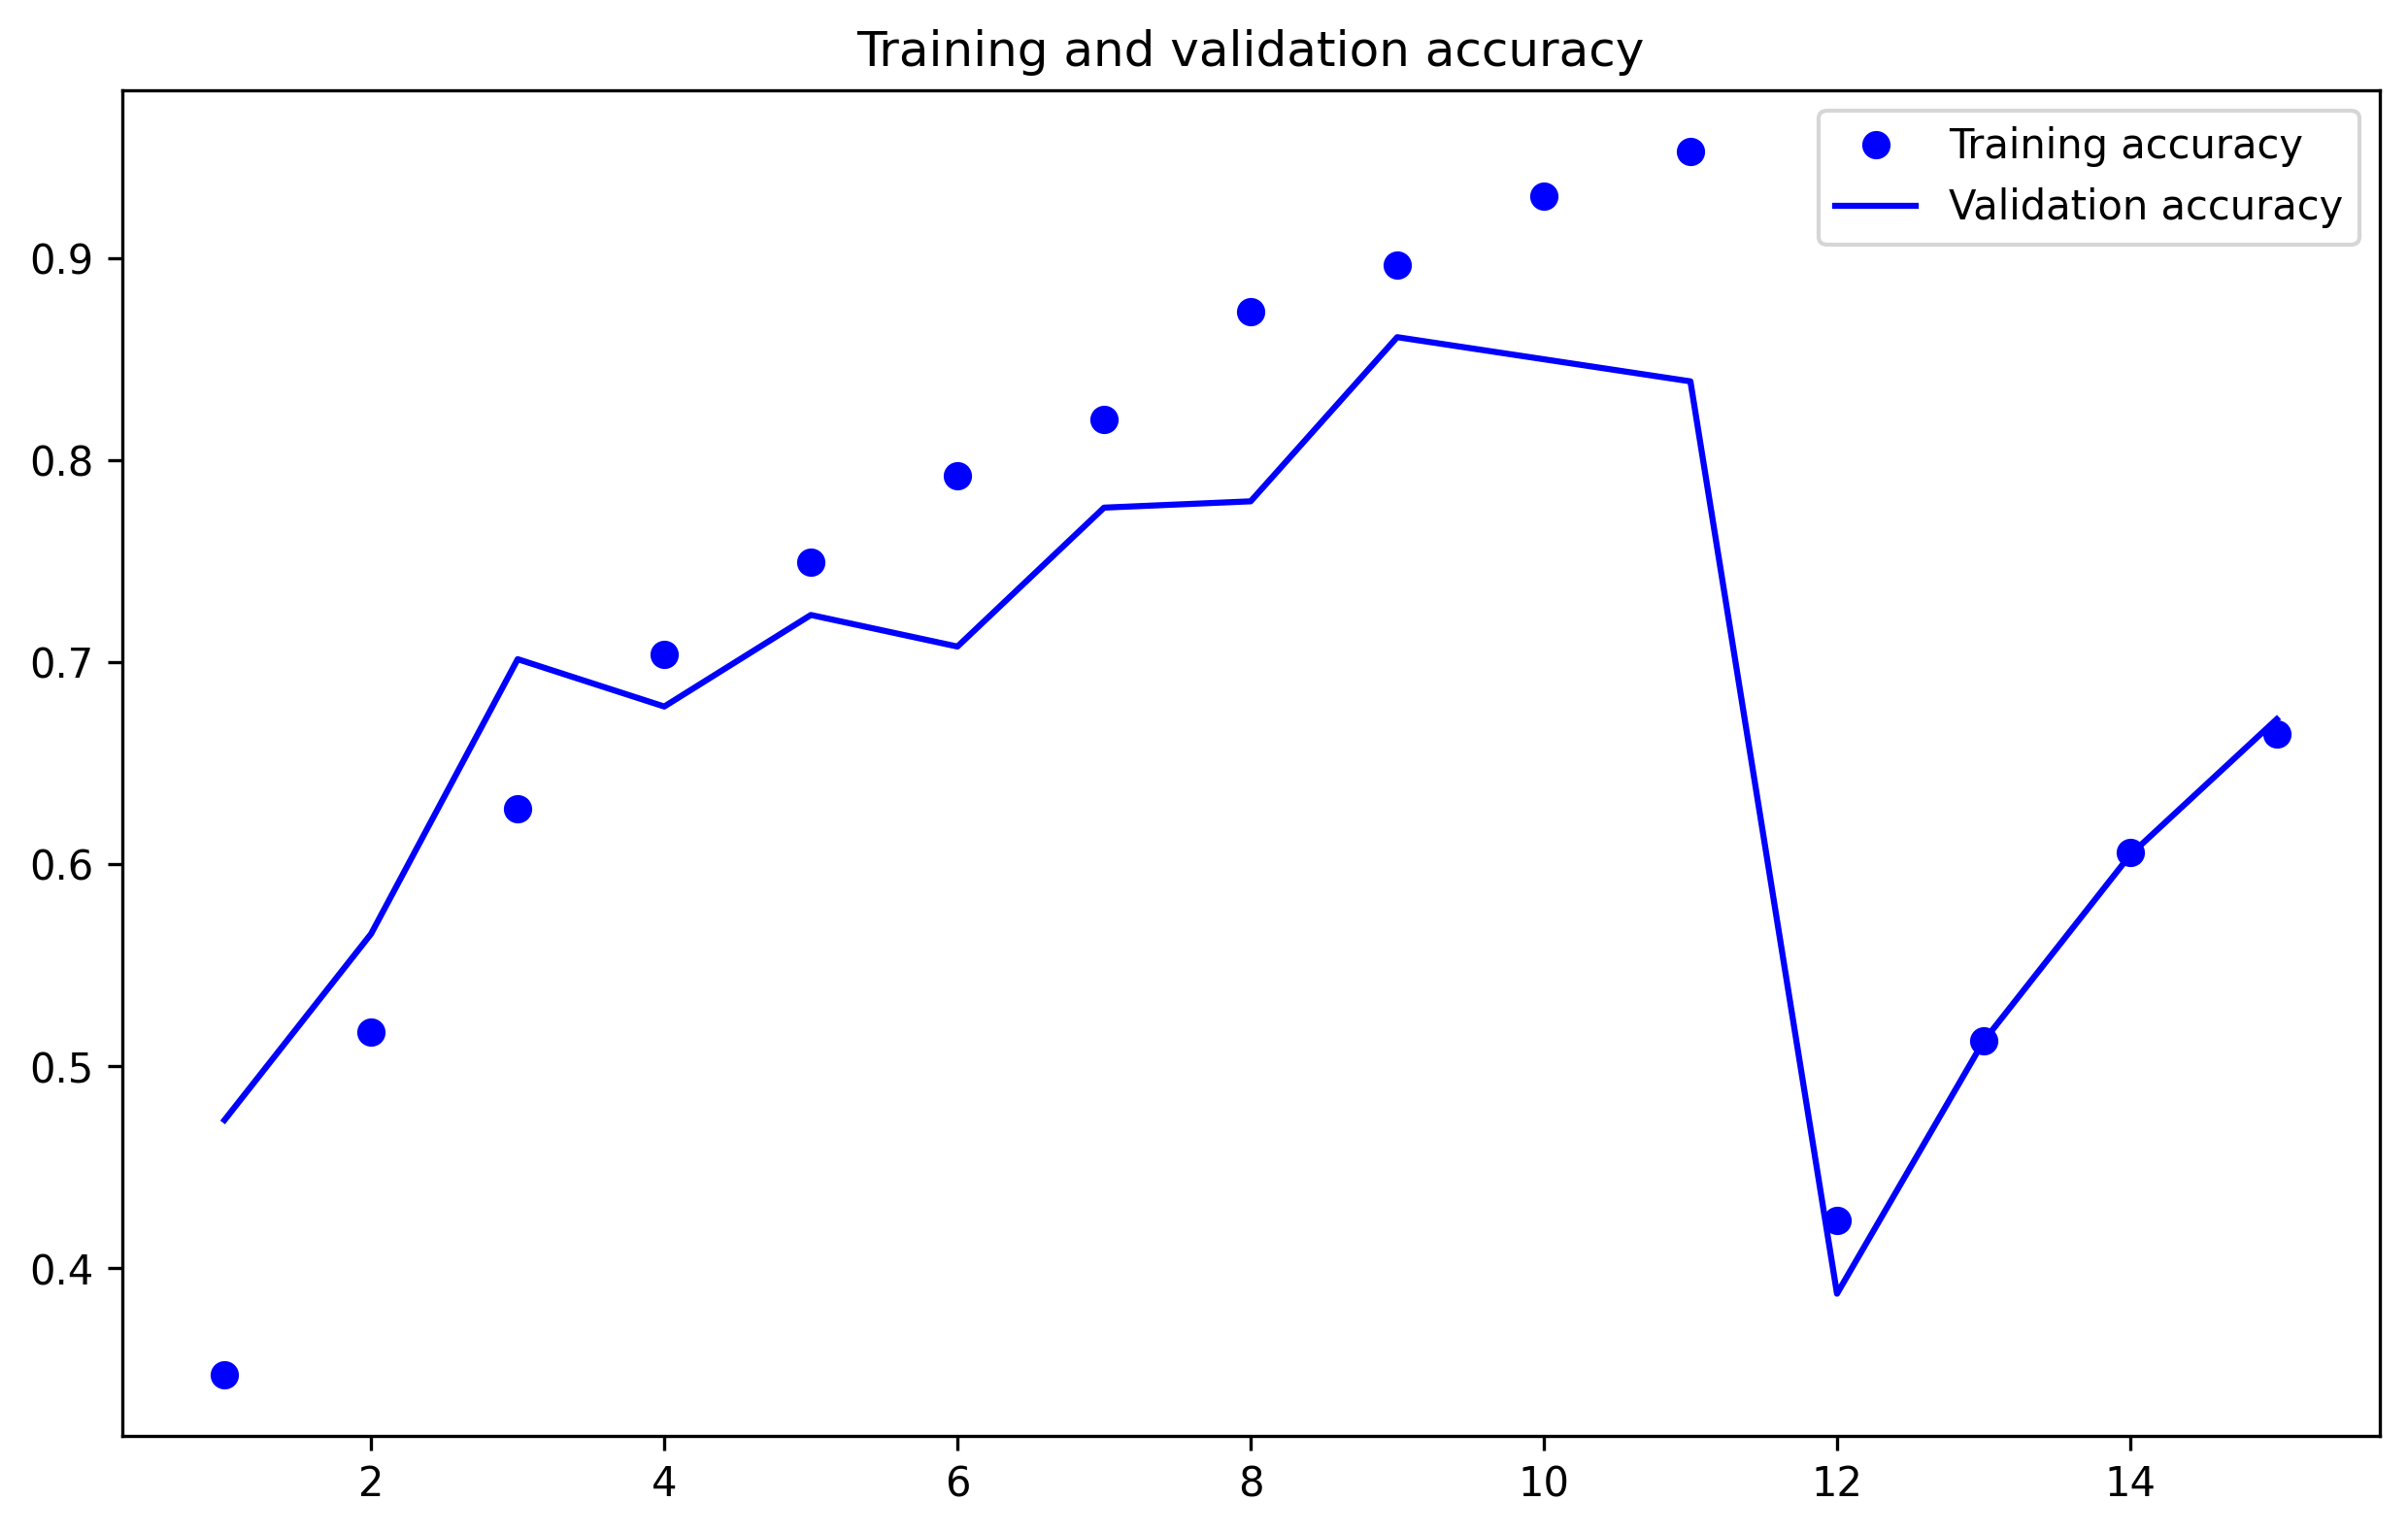

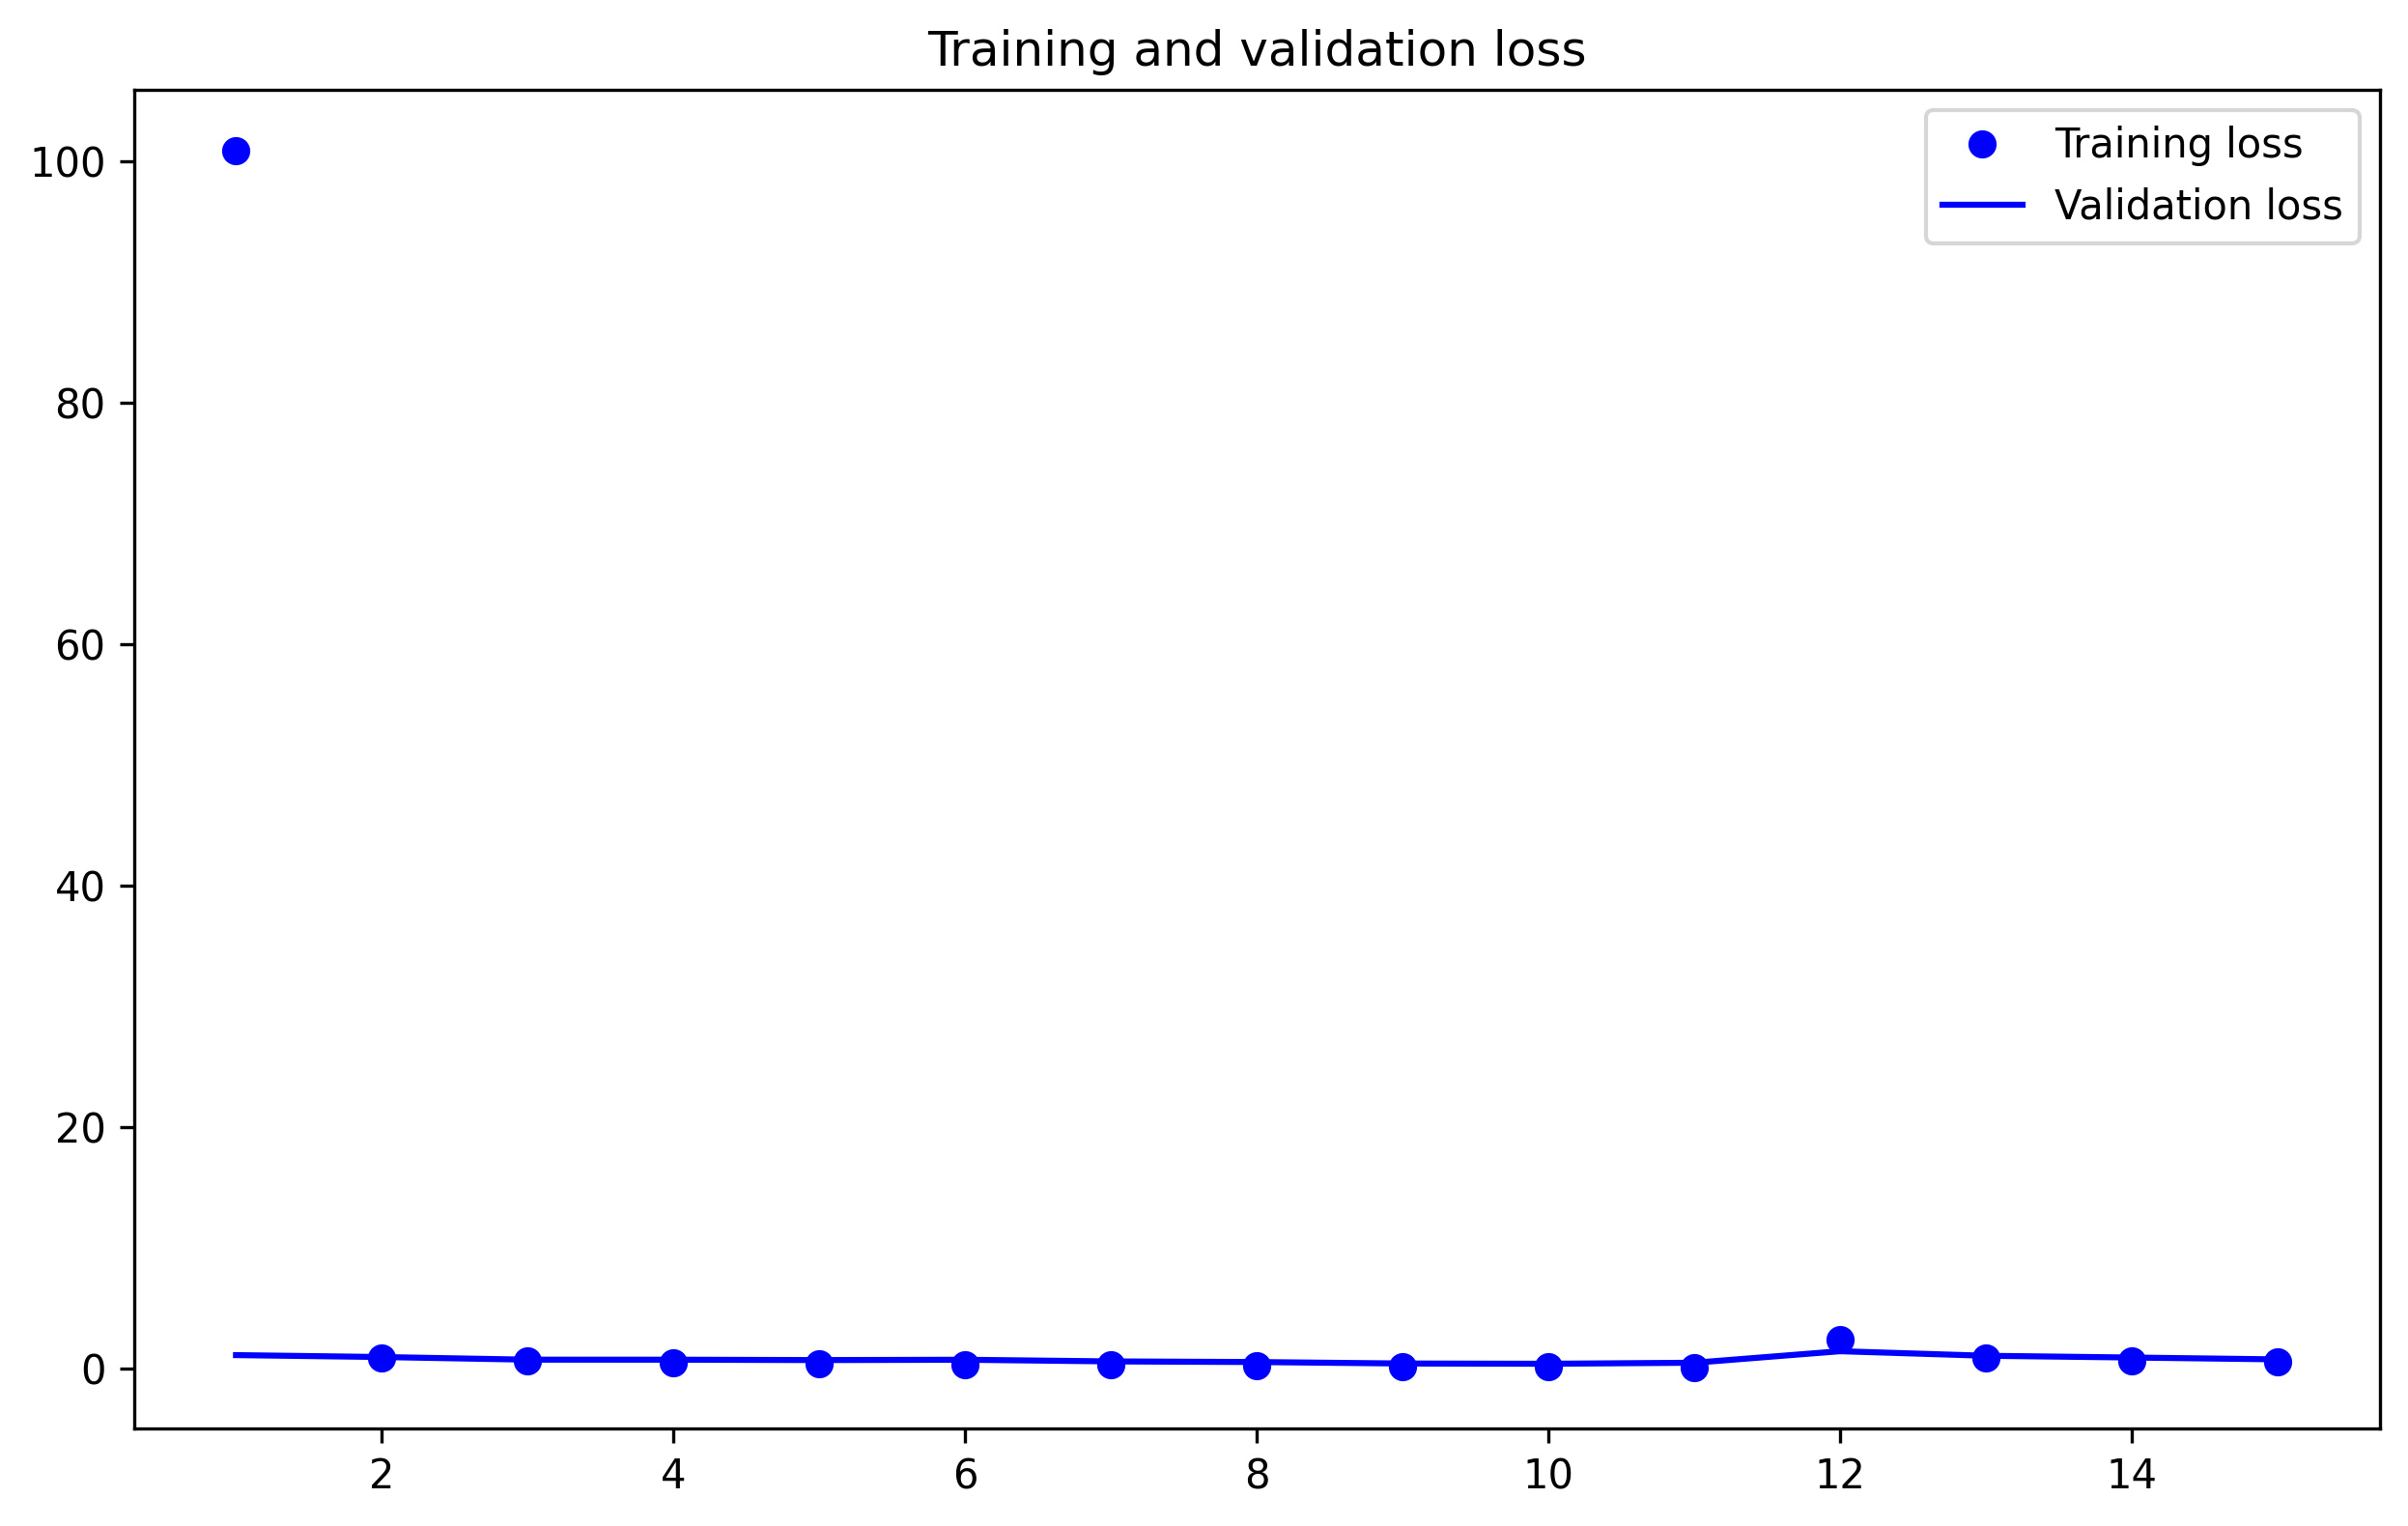

In [67]:
accuracy = history_2.history["accuracy"]
val_accuracy = history_2.history["val_accuracy"]
loss = history_2.history["loss"]
val_loss = history_2.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### **Loss**

* In the first model, the training loss decreases smoothly and the validation loss decreases and then shows minor fluctuations. This indicates that the model is learning effectively, and while there's a hint of variance in the validation loss, it's not significant.
* In the second model, the training loss drops sharply and remains very low, while the validation loss decreases slightly but remains mostly flat. This suggests that the model may not be improving significantly after the initial epochs.


### **Accuracy Trends:**

* For the first model, both training and validation accuracy improve over time, though the validation accuracy shows more variance. This might be due to the model starting to overfit or due to the complexity of the validation data.
* The second model's accuracy for both training and validation sharply increases and then decreases just as sharply. This volatility could be a sign of overfitting, an inappropriate learning rate, or instability in the training process.

### **Gap Between Training and Validation:**

* The first model shows a consistent gap between training and validation accuracy, suggesting a stable but present difference in performance on training versus unseen data.
* The second model's gap between training and validation accuracy widens significantly after the initial epochs, which is indicative of overfitting.


## *Evaluating with test Data*

In [68]:
# model 1
print(model_1.evaluate(test_data))

# model 2

print(model_simplified.evaluate(test_data))

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8790 - loss: 0.4247
[0.39223137497901917, 0.885937511920929]
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.6319 - loss: 0.8574
[0.8403452634811401, 0.6390625238418579]


* Model 1 is performing better on the test data, with a higher accuracy and a lower loss compared to Model 2. This suggests that Model 1 generalizes better to unseen data and is more reliable for making predictions

                                 First model is the better one                                                   

## *Classification Report*

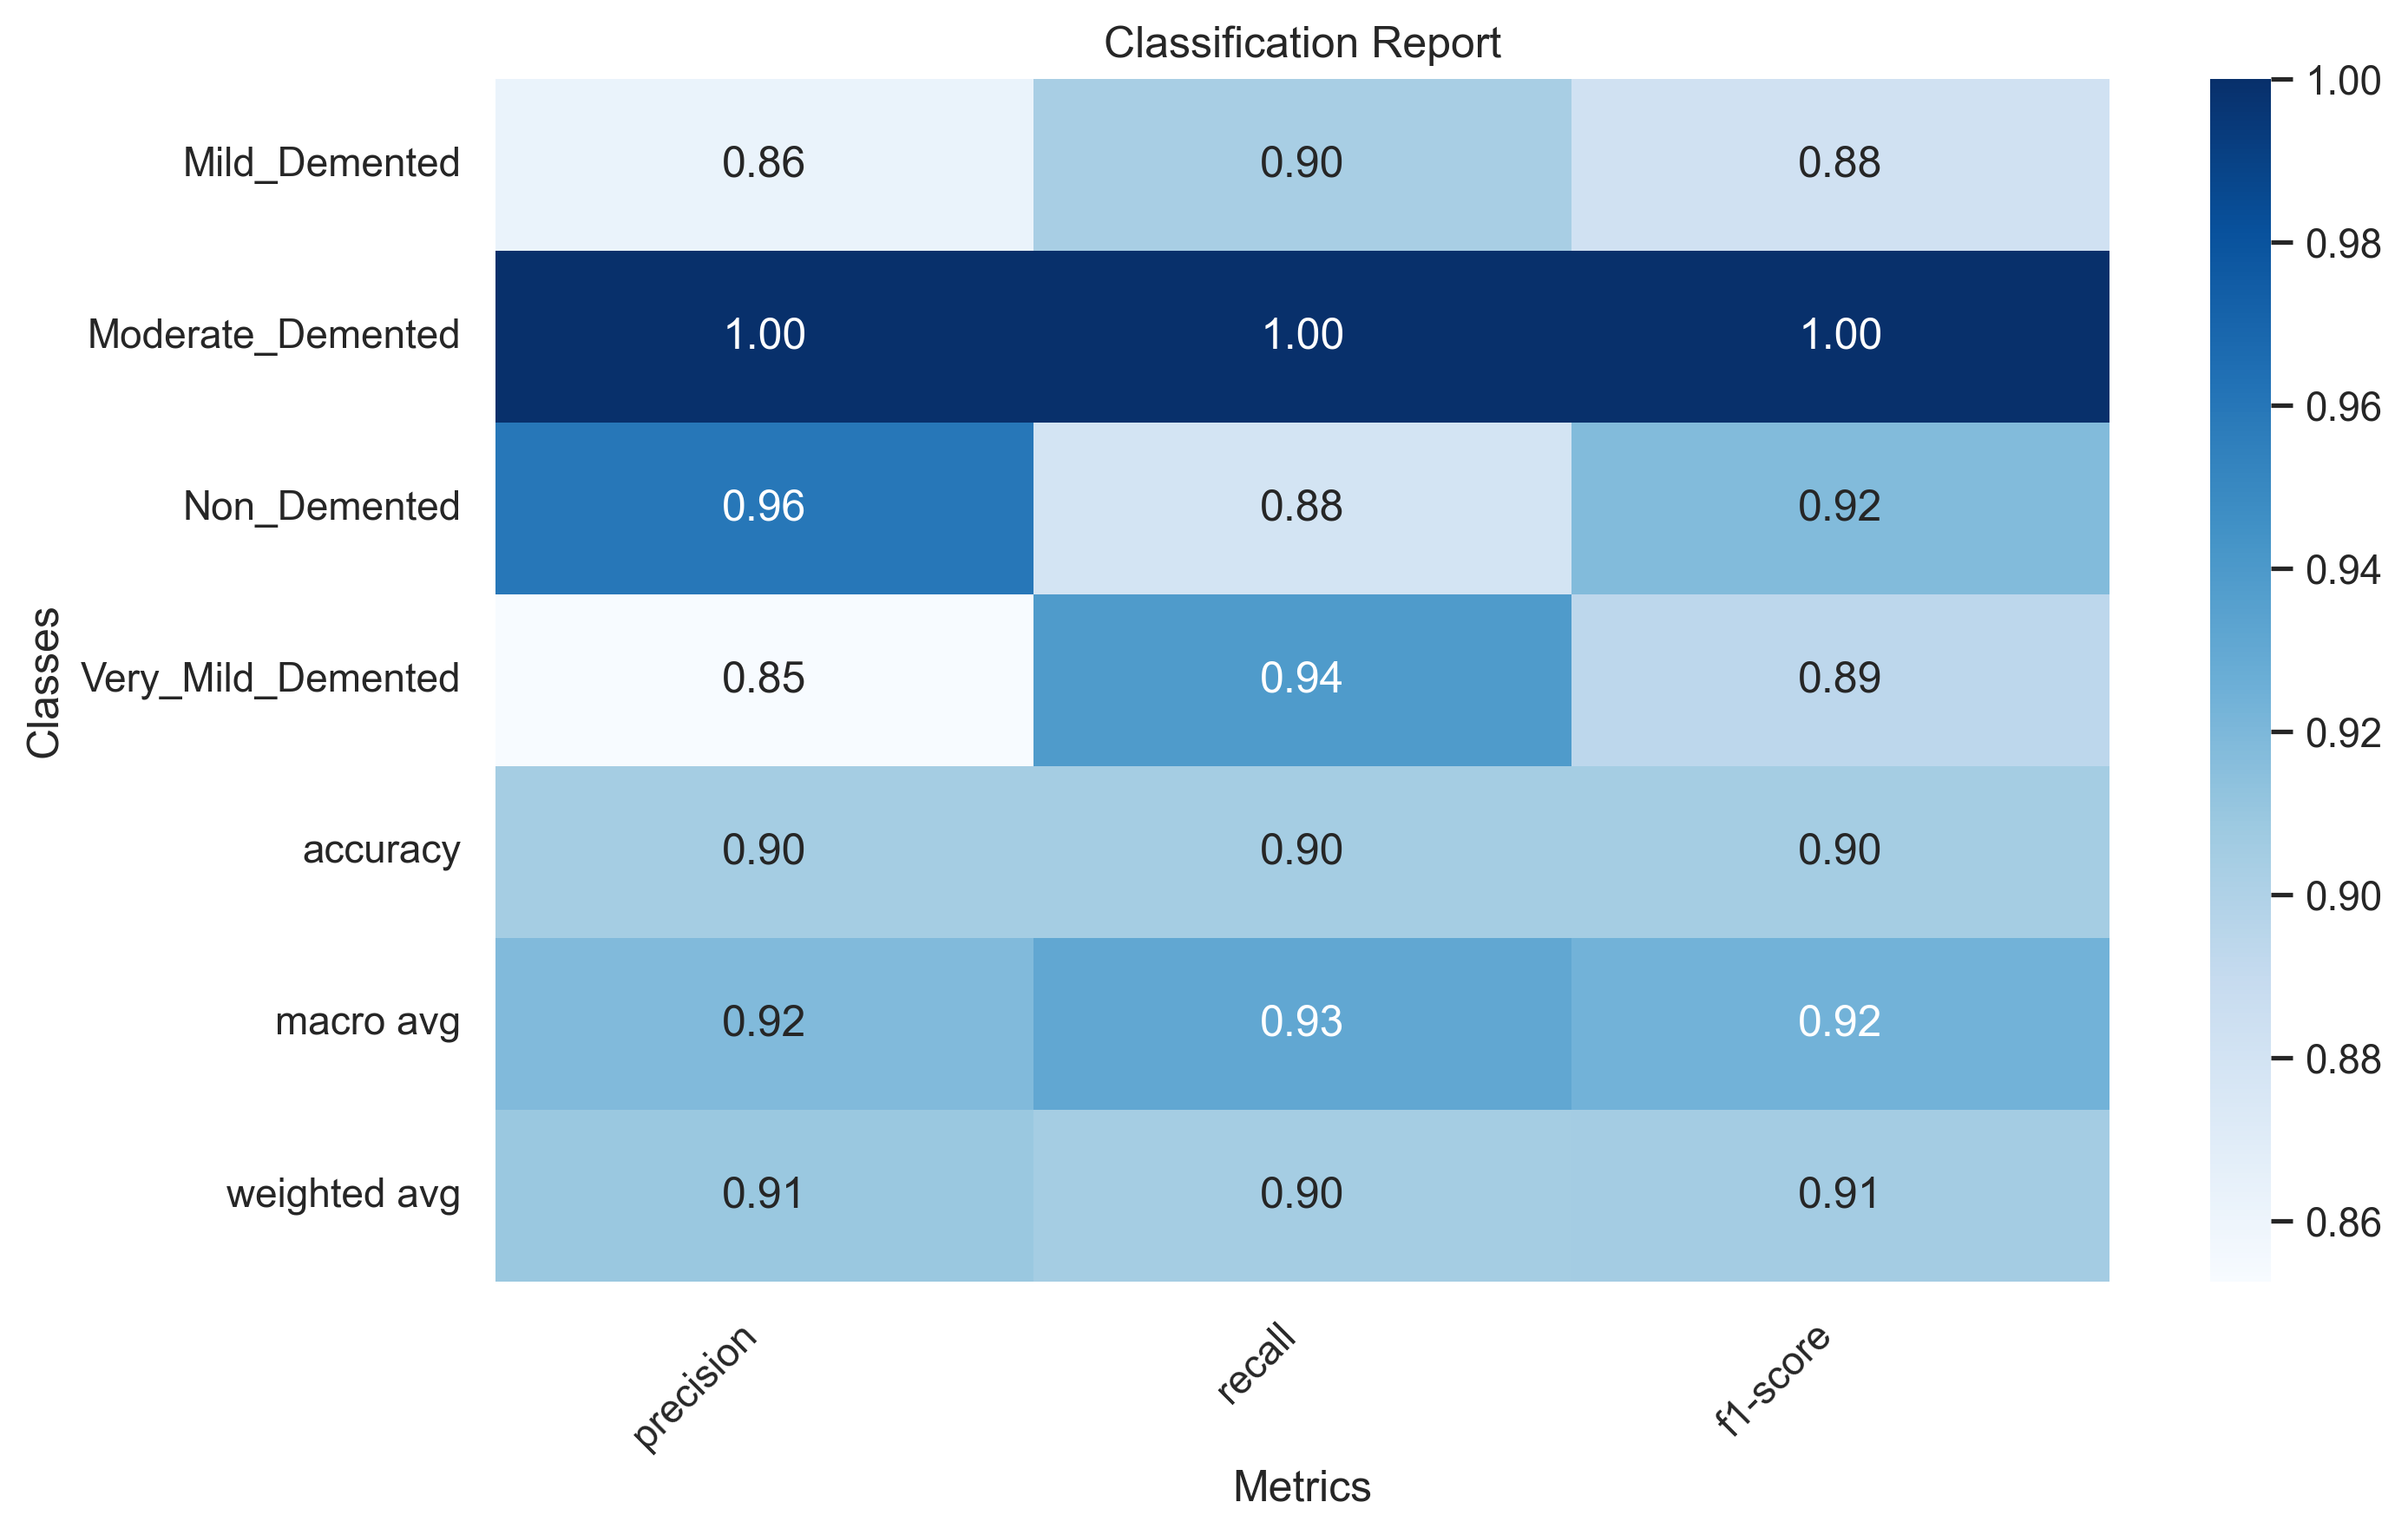

In [75]:
predictions = []
labels = []

for X, y in test_data.as_numpy_iterator():
    y_pred = model_1.predict(X, verbose=0)
    y_prediction = np.argmax(y_pred, axis=1)
    predictions.extend(y_prediction)
    labels.extend(y)
    
predictions = np.array(predictions)
labels = np.array(labels)

report = classification_report(labels, predictions, target_names=class_names, output_dict=True)

# Convert the report dictionary to a DataFrame
df_report = pd.DataFrame(report).transpose()

# Configure the plot with seaborn
sns.set(style="whitegrid")
# Drop the 'support' column to only display the precision, recall, and f1-score
df_plot = df_report.drop(columns=["support"])
# Plotting the heatmap
plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(df_plot, annot=True, cmap="Blues", cbar=True, fmt=".2f")
plt.title('Classification Report')
plt.xlabel('Metrics')
plt.ylabel('Classes')

# This adjustment helps in case labels overlap with the heatmap cells
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.show()

## *Confusion Matrix*

Text(275.24999999999994, 0.5, 'True')

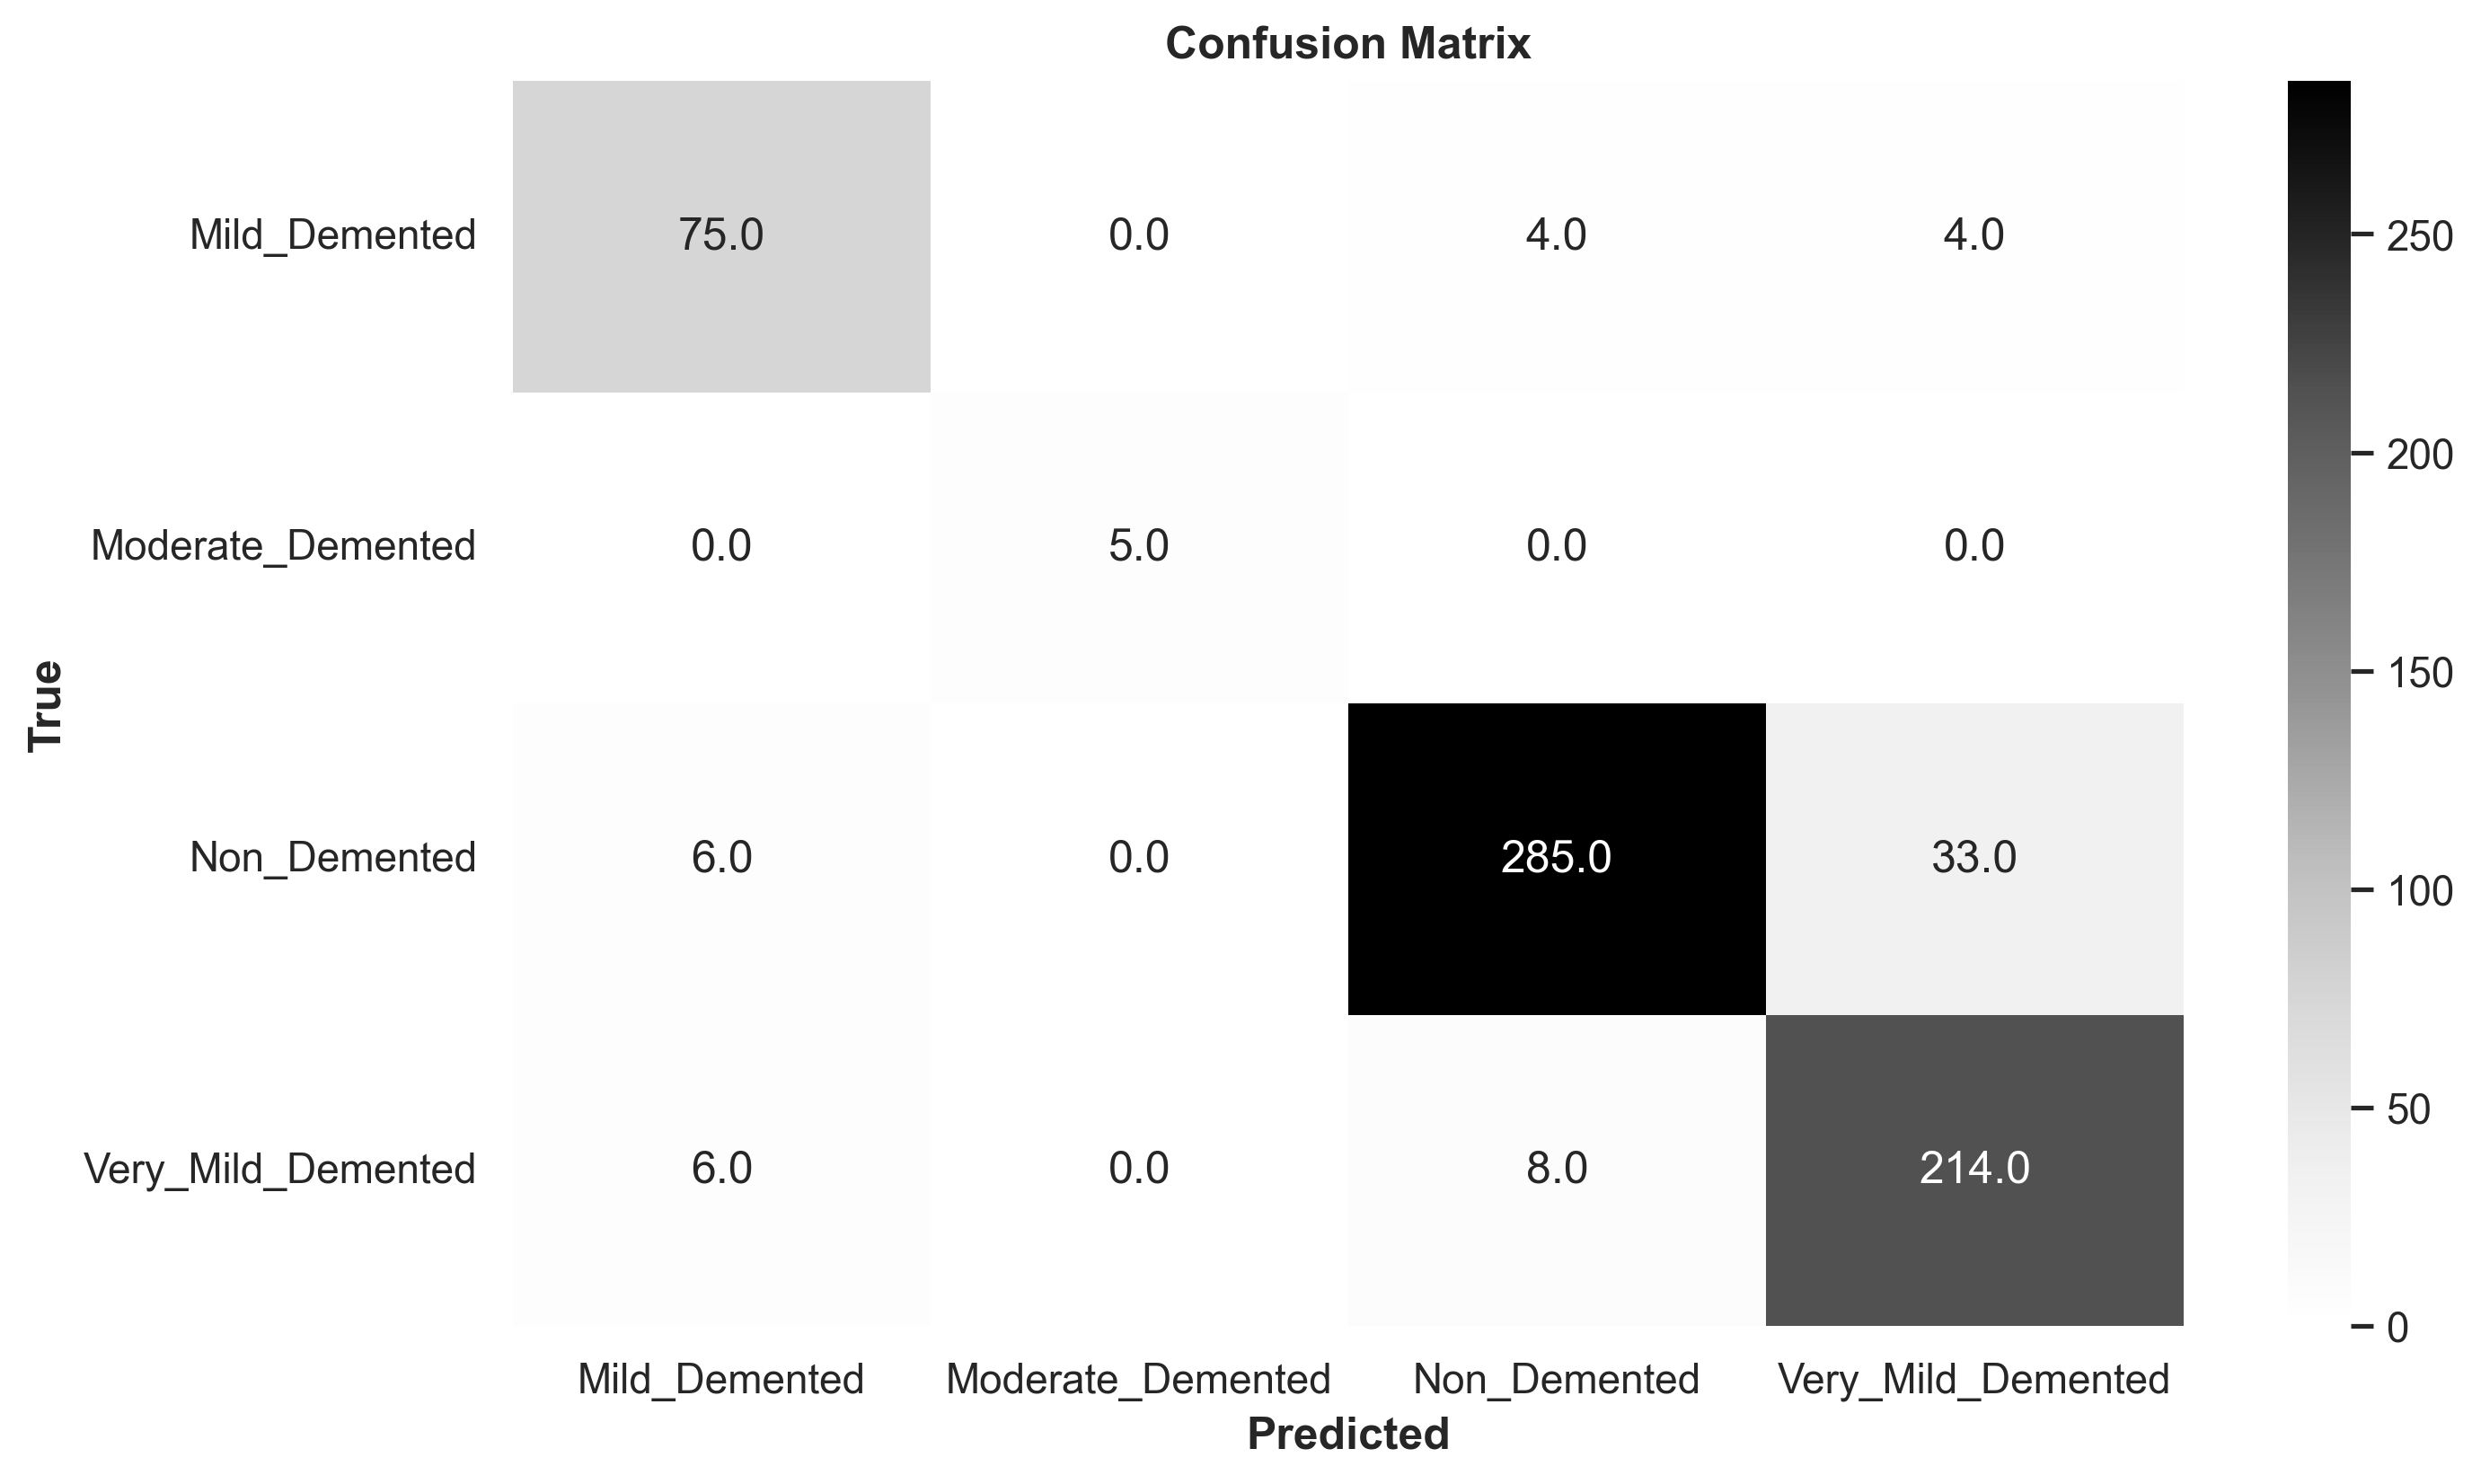

In [76]:
cm = confusion_matrix(labels, predictions)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
cm_df
plt.figure(figsize=(10,6), dpi=300)
sns.heatmap(cm_df, annot=True, cmap="Greys", fmt=".1f")
plt.title("Confusion Matrix", fontweight="bold")
plt.xlabel("Predicted", fontweight="bold")
plt.ylabel("True", fontweight="bold")

## *Comparing Predicted Classes with the Actual Classes from the Test Data*

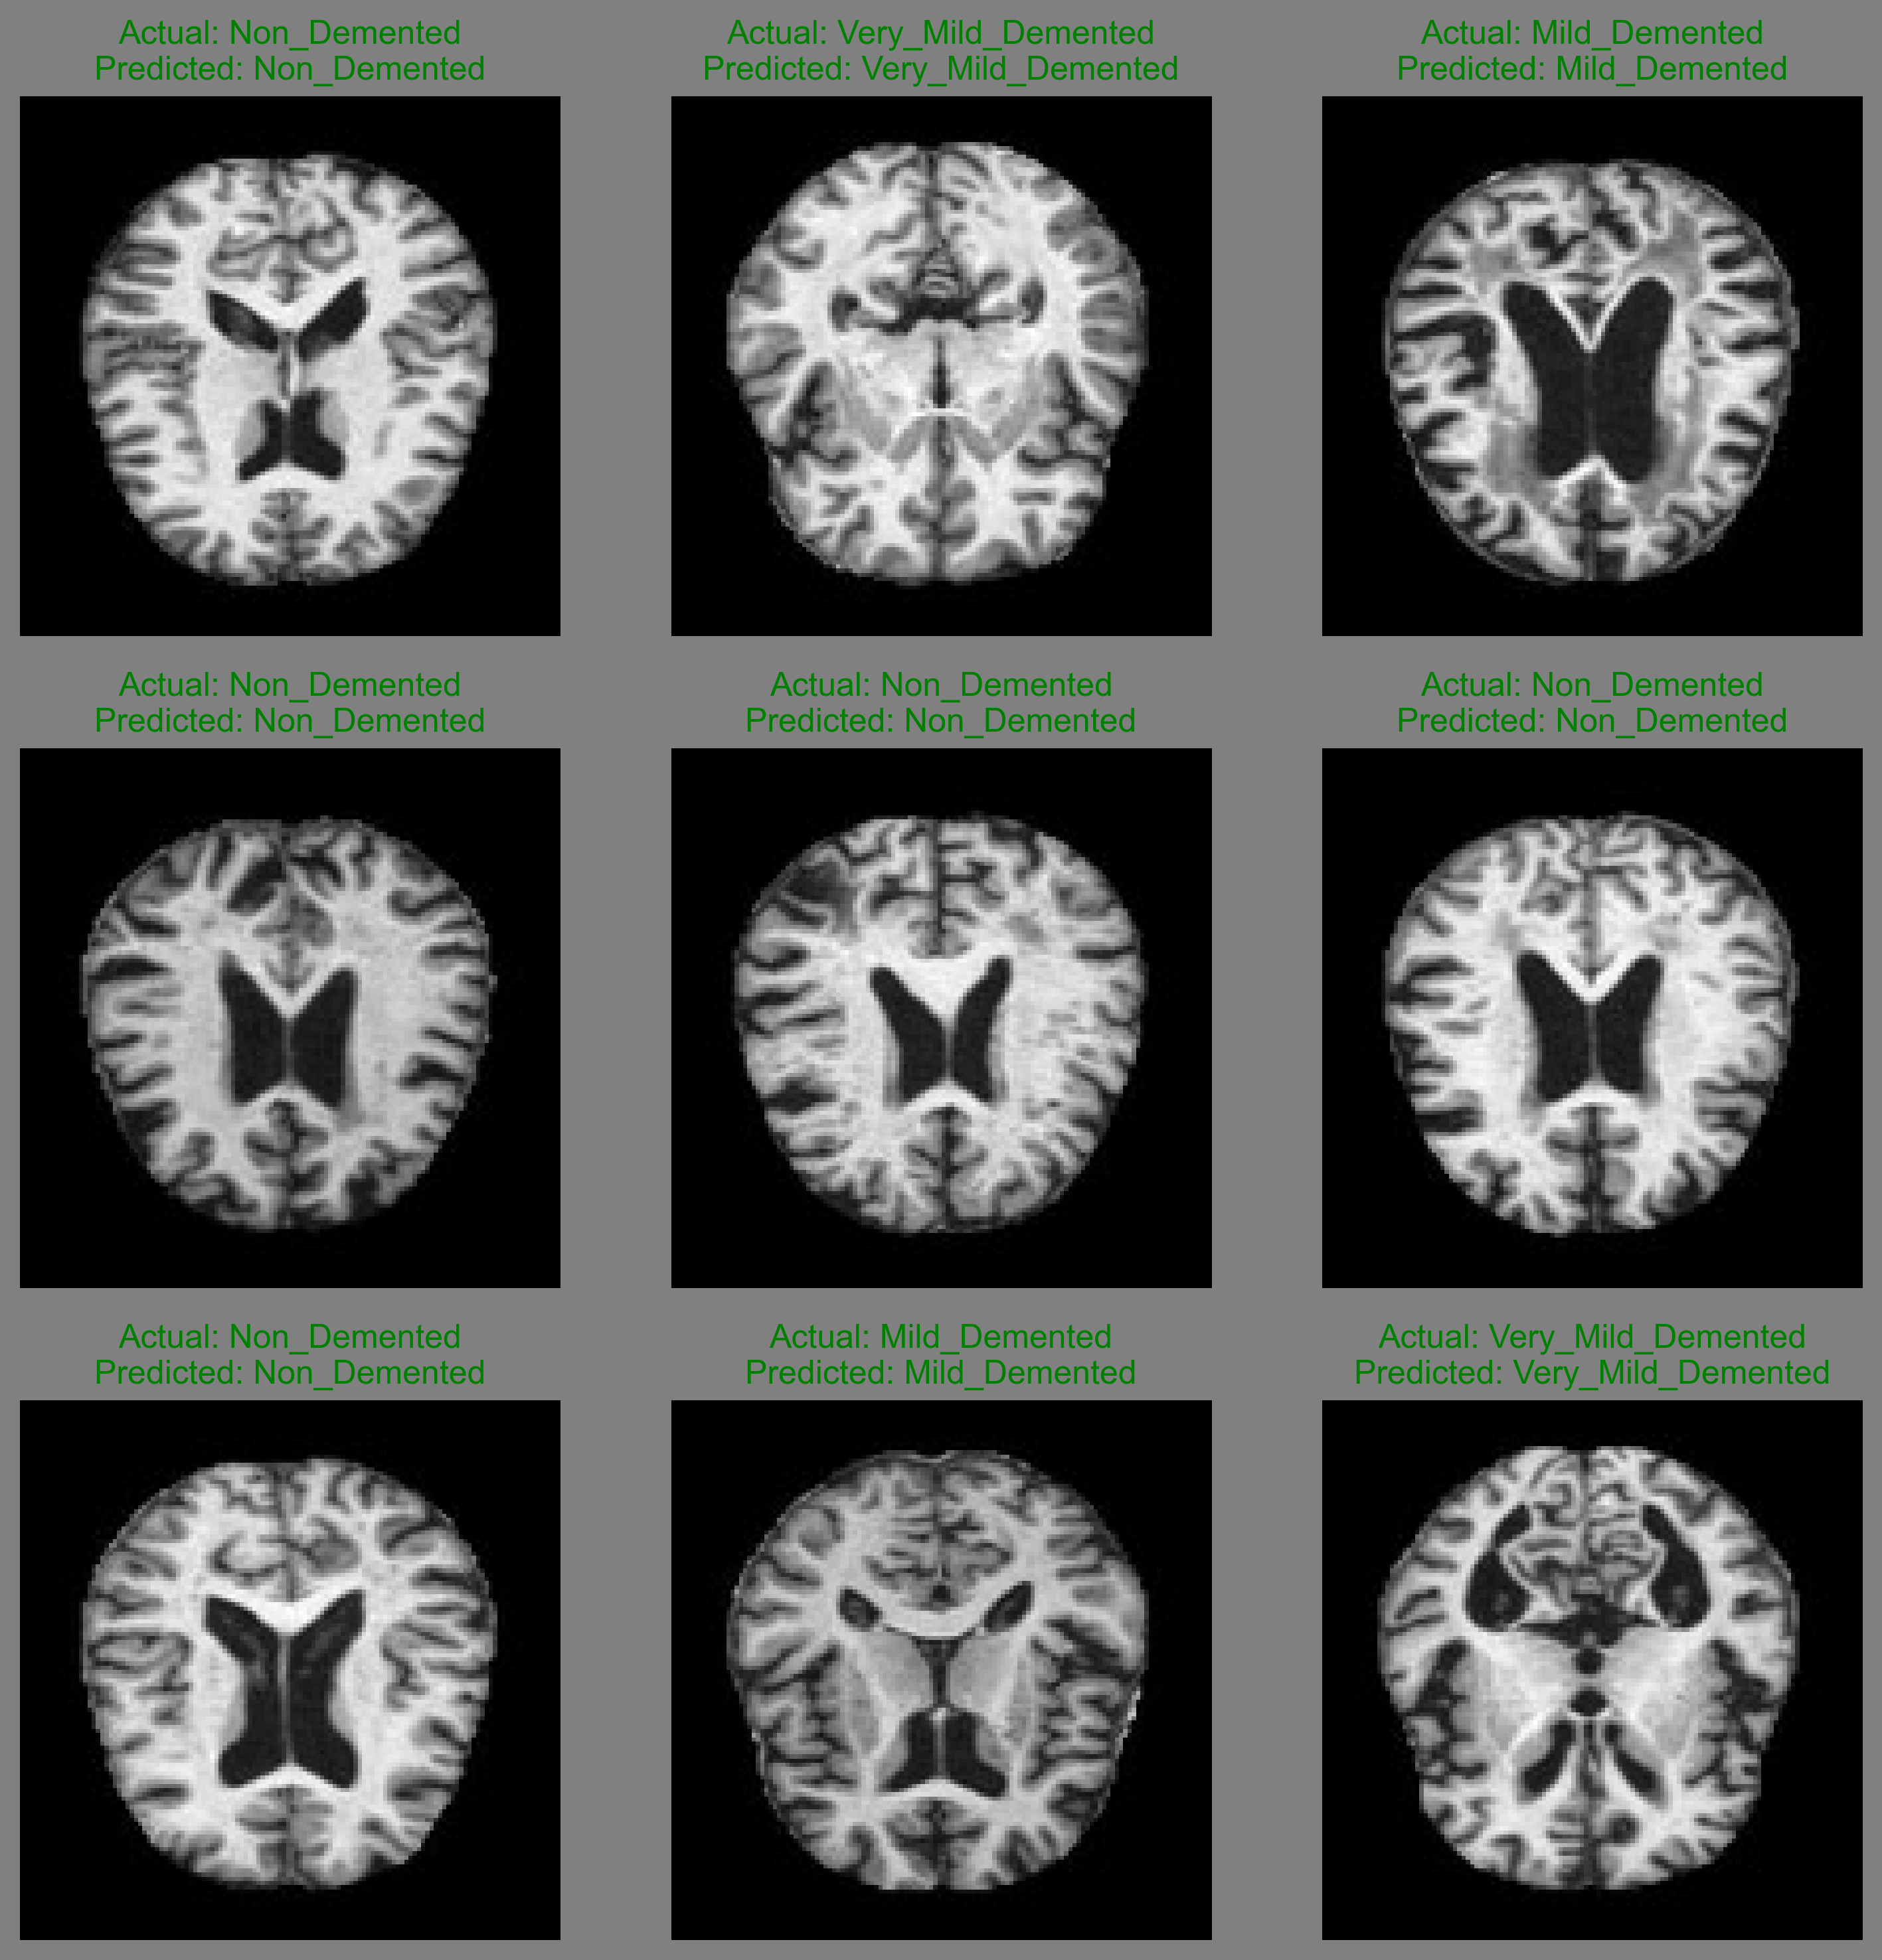

In [91]:
def display_predictions(model, test_data, class_names):
    plt.figure(figsize=(10, 10), facecolor='gray')

    # Taking one batch from the test data
    for images, labels in test_data.take(1):
        # Get predictions for the entire batch
        predictions = model.predict(images, verbose=0)
        predicted_classes = np.argmax(predictions, axis=1)
        
        # Display the first 9 images from the batch
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            actual = class_names[labels[i]]
            predicted = class_names[predicted_classes[i]]
            color = "green" if actual == predicted else "red"
            plt.title(f'Actual: {actual}\nPredicted: {predicted}', color=color)
            plt.axis("off")
    
    plt.tight_layout()
    plt.show()
display_predictions(model_1, test_data, class_names)
